# full archive

In [ ]:
# !pip install transformers torch matplotlib seaborn

In [ ]:
import os
import copy
import torch
from transformers import GPT2Model, GPT2Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the list of model names
model_names = [
    'shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD'
]

# Sample input text
sample_text = "Once upon a time in a land far, far away, there lived a wise old owl."

# Directory to save attention plots
output_dir = "attention_plots"
os.makedirs(output_dir, exist_ok=True)

# Initialize the tokenizer once since all models share the same tokenizer settings
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.cls_token = "[CLS]"
tokenizer.add_special_tokens({'cls_token': '[CLS]'})  # Ensure special tokens are added


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD
  Processed Layer 4/12
  Processed Layer 8/12
  Processed Layer 12/12
Processing model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

  Processed Layer 4/12
  Processed Layer 8/12
  Processed Layer 12/12
Processing model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD


config.json:   0%|          | 0.00/854 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

  Processed Layer 4/12
  Processed Layer 8/12
  Processed Layer 12/12
Processing model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

  Processed Layer 4/12
  Processed Layer 8/12
  Processed Layer 12/12


<ipython-input-6-fa2847a5dd5f>:61: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


All attention heatmaps have been plotted and saved to attention_plots/all_models_attention_comparison.png


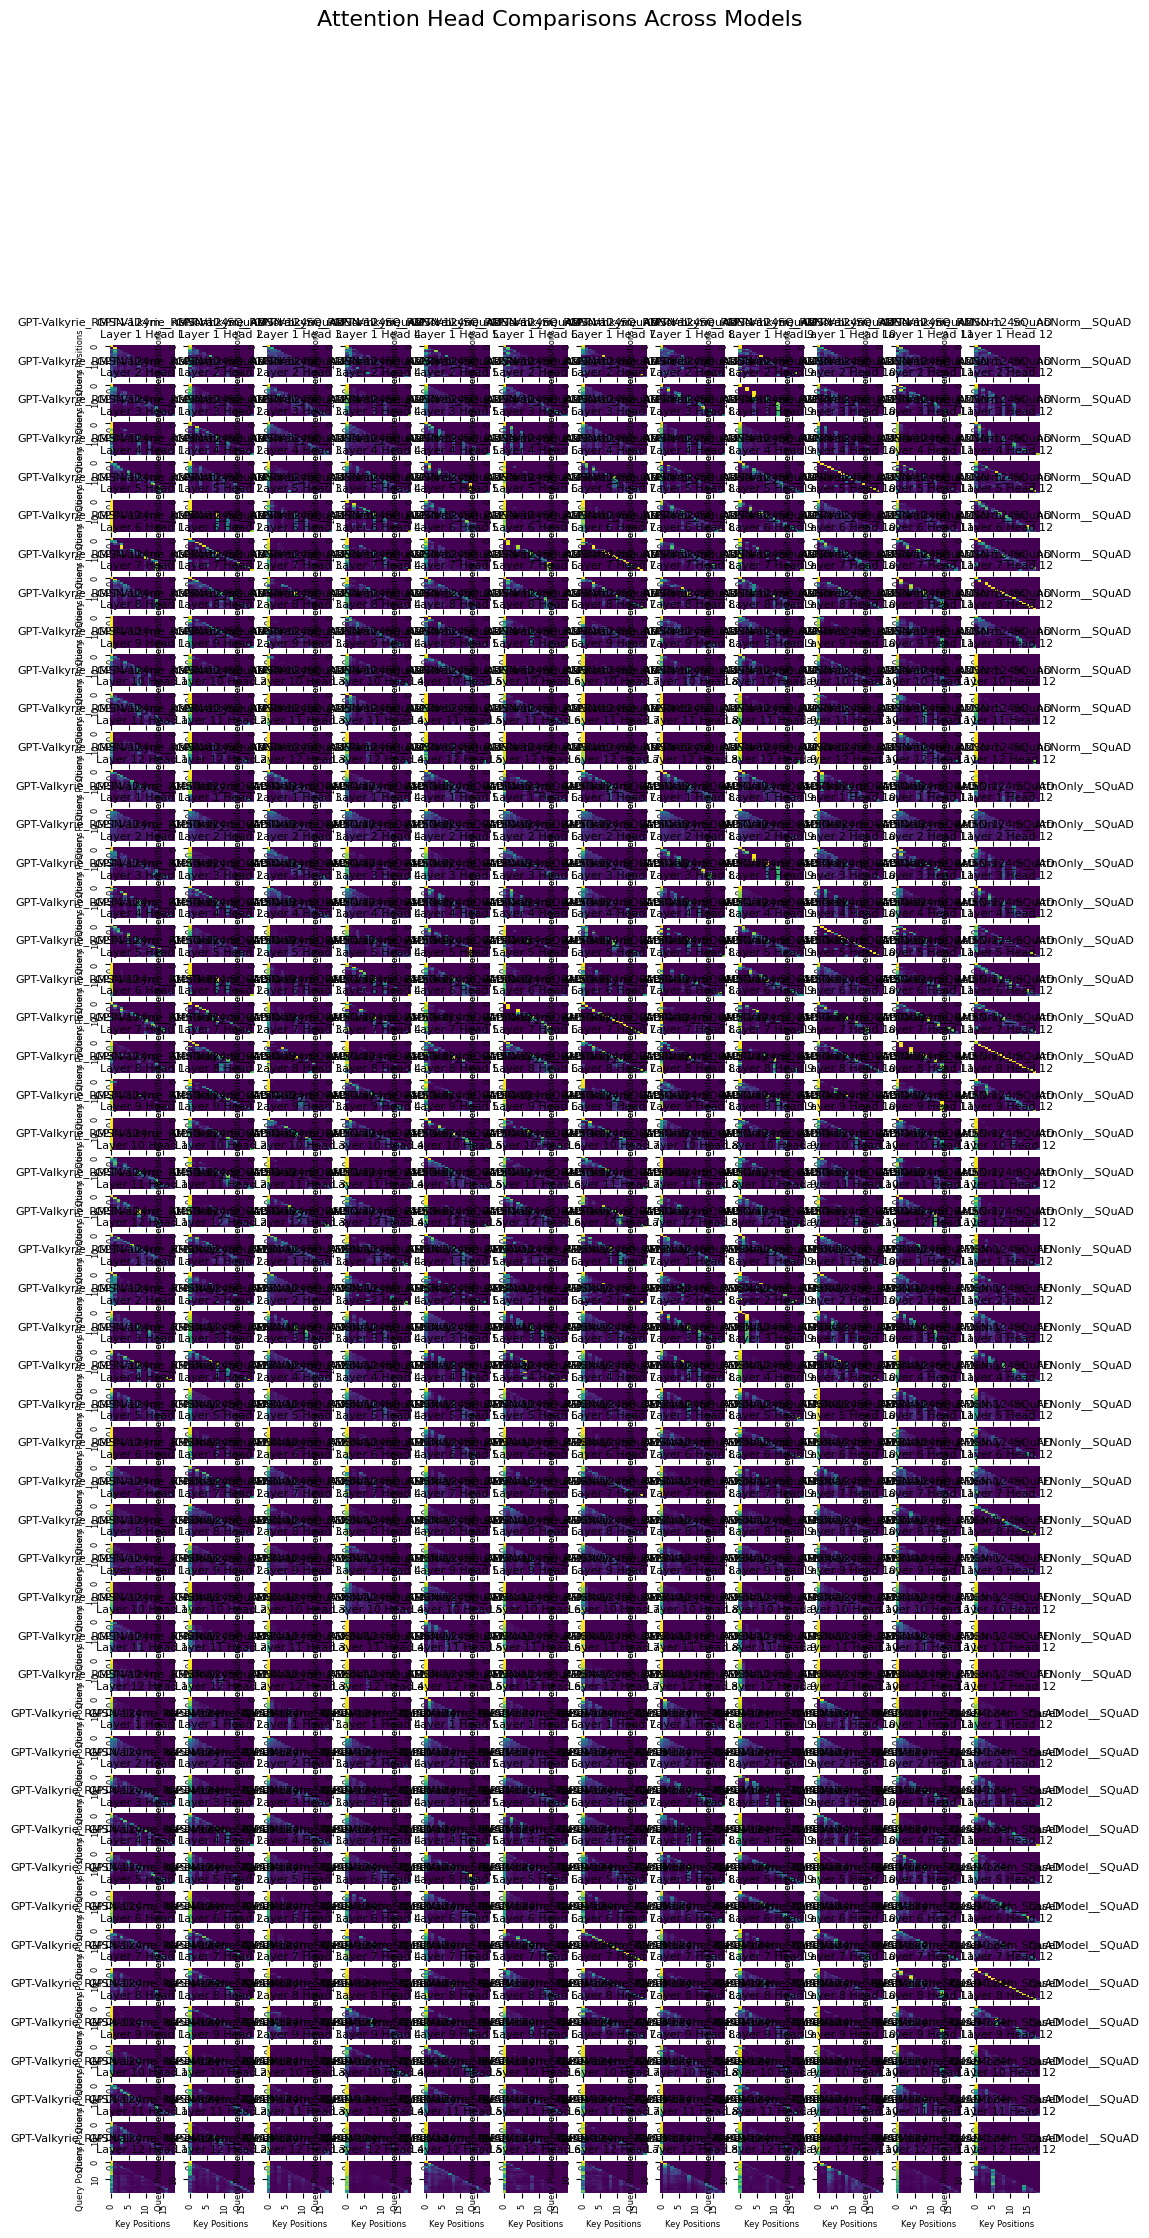

In [ ]:
# Function to plot a single attention heatmap
def plot_attention(ax, attention, layer, head, model_name):
    sns.heatmap(attention, cmap='viridis', ax=ax, cbar=False)
    ax.set_title(f'{model_name}\nLayer {layer+1} Head {head+1}', fontsize=8)
    ax.set_xlabel('Key Positions', fontsize=6)
    ax.set_ylabel('Query Positions', fontsize=6)
    ax.tick_params(labelsize=6)

# Initialize the figure
num_models = len(model_names)
num_layers = 12  # Assuming GPT-2 base with 12 layers
num_heads = 12   # Assuming GPT-2 base with 12 heads per layer

# Define subplot grid: models vertically, layers within models, heads within layers
fig_height = num_models * num_layers * 0.5  # Adjust the height per layer
fig_width = num_heads * 1.0  # Adjust the width per head
fig, axes = plt.subplots(num_models * num_layers, num_heads, figsize=(num_heads * 1.0, num_models * num_layers * 0.5))

# Ensure axes is a 2D array even if num_heads=1
if num_models * num_layers == 1:
    axes = np.array([axes])
elif num_heads == 1:
    axes = axes.reshape(num_models * num_layers, 1)

# Iterate over each model
for model_idx, model_name in enumerate(model_names):
    print(f"Processing model: {model_name}")

    # Load the model with attention outputs
    model = GPT2Model.from_pretrained(model_name, output_attentions=True)
    model.eval()  # Set model to evaluation mode

    # Tokenize the input
    inputs = tokenizer(sample_text, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Get the attention outputs
    with torch.no_grad():
        outputs = model(**inputs)
    attentions = outputs.attentions  # List of tensors: one for each layer

    # Iterate over each layer
    for layer in range(num_layers):
        # Iterate over each head in the layer
        for head in range(num_heads):
            # Calculate the absolute position in the axes grid
            plot_idx = model_idx * num_layers + layer
            ax = axes[plot_idx, head] if num_heads > 1 else axes[plot_idx]

            # Extract attention weights for this layer and head
            # Shape: (batch_size, num_heads, seq_length, seq_length)
            attention = attentions[layer][0, head].cpu().numpy()

            # Plot the attention heatmap
            plot_attention(ax, attention, layer, head, model_name.split('/')[-1])

        if (layer + 1) % 4 == 0:
            print(f"  Processed Layer {layer+1}/{num_layers}")

# Adjust layout
plt.tight_layout()

# Add a main title
plt.suptitle('Attention Head Comparisons Across Models', fontsize=16, y=1.02)

# Save the figure
fig_file = os.path.join(output_dir, 'all_models_attention_comparison.png')
plt.savefig(fig_file, bbox_inches='tight', dpi=300)
print(f"All attention heatmaps have been plotted and saved to {fig_file}")

# Show the plot
plt.show()

# Averaging Heads across each Layer

In [ ]:
import os
import torch
from transformers import GPT2Model, GPT2Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

# Define the list of model names
model_names = [
    'shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD'
]

# Sample input text
sample_text = "Once upon a time in a land far, far away, there lived a wise old owl."

# Directory to save attention plots (optional)
output_dir = "attention_plots_layer_avg"
os.makedirs(output_dir, exist_ok=True)

# Initialize the tokenizer once since all models share the same tokenizer settings
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.cls_token = "[CLS]"
# Add special tokens only once
if '[CLS]' not in tokenizer.get_vocab():
    tokenizer.add_special_tokens({'cls_token': '[CLS]'})

# Function to plot a single attention heatmap
def plot_attention(ax, attention, layer, model_name):
    sns.heatmap(attention, cmap='viridis', ax=ax, cbar=False)
    ax.set_title(f'{model_name}\nLayer {layer+1}', fontsize=8)
    ax.set_xlabel('Key Positions', fontsize=6)
    ax.set_ylabel('Query Positions', fontsize=6)
    ax.tick_params(labelsize=6)

# Iterate over each model
for model_name in model_names:
    print(f"Processing model: {model_name}")

    # Load the model with attention outputs
    model = GPT2Model.from_pretrained(model_name, output_attentions=True)
    model.eval()  # Set model to evaluation mode

    # Tokenize the input
    inputs = tokenizer(sample_text, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Get the attention outputs
    with torch.no_grad():
        outputs = model(**inputs)
    attentions = outputs.attentions  # List of tensors: one for each layer

    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]  # Assuming all layers have the same number of heads
    seq_length = attentions[0].shape[-1]

    print(f"Number of layers: {num_layers}, Number of heads per layer: {num_heads}, Sequence length: {seq_length}")

    # Prepare a grid for plotting: e.g., 4 rows (layers) x 3 cols (heads) for 12 layers
    # Adjust grid size based on number of layers
    cols = 6  # Number of columns in the grid
    rows = int(np.ceil(num_layers / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle(f'Layer-wise Averaged Attention - {model_name.split("/")[-1]}', fontsize=12)

    for layer in range(num_layers):
        # Average attention across heads
        attention_avg = attentions[layer].mean(dim=1).squeeze(0).cpu().numpy()

        # Determine subplot position
        row = layer // cols
        col = layer % cols

        ax = axs[row, col] if rows > 1 else axs[col]

        # Plot the averaged attention
        plot_attention(ax, attention_avg, layer, model_name.split('/')[-1])

    # Remove any empty subplots
    total_subplots = rows * cols
    if num_layers < total_subplots:
        for empty in range(num_layers, total_subplots):
            row = empty // cols
            col = empty % cols
            ax = axs[row, col] if rows > 1 else axs[col]
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save the figure
    save_path = os.path.join(output_dir, f'{model_name.split("/")[-1]}_layer_avg_attention.png')
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved averaged attention plots for model: {model_name}\n")

print("All models have been processed and layer-averaged attention heatmaps have been saved.")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD


config.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Saved averaged attention plots for model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD


config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Saved averaged attention plots for model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD


config.json:   0%|          | 0.00/854 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Saved averaged attention plots for model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Saved averaged attention plots for model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD

All models have been processed and layer-averaged attention heatmaps have been saved.


# Averaging Head across each Layer BUT all 4 MODELS in SAME PICTURE

In [ ]:
import os
import torch
from transformers import GPT2Model, GPT2Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the list of model names
model_names = [
    'shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD'
]

# Sample input text
sample_text = "Once upon a time in a land far, far away, there lived a wise old owl."

# Directory to save the comprehensive attention plot
output_dir = "attention_plots_comprehensive"
os.makedirs(output_dir, exist_ok=True)

# Initialize the tokenizer once since all models share the same tokenizer settings
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.cls_token = "[CLS]"
# Add special tokens only once
if '[CLS]' not in tokenizer.get_vocab():
    tokenizer.add_special_tokens({'cls_token': '[CLS]'})

# Function to plot a single attention heatmap
def plot_attention(ax, attention, layer_num):
    sns.heatmap(attention, cmap='viridis', ax=ax, cbar=False)
    ax.set_title(f'Layer {layer_num+1}', fontsize=8)
    ax.set_xlabel('Key Positions', fontsize=6)
    ax.set_ylabel('Query Positions', fontsize=6)
    ax.tick_params(labelsize=4)

# Initialize the figure with subplots
num_models = len(model_names)
num_layers = 12  # Assuming each model has 12 layers
fig, axs = plt.subplots(num_models, num_layers, figsize=(num_layers * 1.5, num_models * 1.5), constrained_layout=True)
fig.suptitle('Attention Heatmaps Across Models and Layers', fontsize=16)

# To ensure consistent color scaling across all heatmaps, find the global max and min
global_max = -np.inf
global_min = np.inf

# First pass to determine global min and max for color scaling
for model_name in model_names:
    print(f"Determining color scale for model: {model_name}")
    model = GPT2Model.from_pretrained(model_name, output_attentions=True)
    model.eval()
    inputs = tokenizer(sample_text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    attentions = outputs.attentions[:num_layers]  # Ensure only the first 12 layers are considered
    layer_avg_attentions = [attn.mean(dim=1).squeeze(0).cpu().numpy() for attn in attentions]
    overall_avg_attention = np.mean(layer_avg_attentions, axis=0)
    current_max = np.max(overall_avg_attention)
    current_min = np.min(overall_avg_attention)
    if current_max > global_max:
        global_max = current_max
    if current_min < global_min:
        global_min = current_min

# Second pass to plot with consistent color scaling
for model_idx, model_name in enumerate(model_names):
    print(f"Processing model: {model_name}")

    # Load the model with attention outputs
    model = GPT2Model.from_pretrained(model_name, output_attentions=True)
    model.eval()  # Set model to evaluation mode

    # Tokenize the input
    inputs = tokenizer(sample_text, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Get the attention outputs
    with torch.no_grad():
        outputs = model(**inputs)
    attentions = outputs.attentions[:num_layers]  # Ensure only the first 12 layers are considered

    # Iterate over each layer
    for layer_idx, attn in enumerate(attentions):
        # Average attention across heads
        avg_attn = attn.mean(dim=1).squeeze(0).cpu().numpy()

        # Determine subplot position
        ax = axs[model_idx, layer_idx] if num_models > 1 else axs[layer_idx]

        # Plot the attention heatmap with consistent color scale
        sns.heatmap(avg_attn, cmap='viridis', ax=ax, cbar=False, vmin=global_min, vmax=global_max)
        ax.set_title(f'Layer {layer_idx+1}', fontsize=8)
        ax.set_xlabel('Key Pos', fontsize=6)
        ax.set_ylabel('Query Pos', fontsize=6)
        ax.tick_params(labelsize=4)

    # Set the model name on the left side of the row
    if num_layers > 1:
        axs[model_idx, 0].set_ylabel(f"{model_name.split('/')[-1]}", rotation=90, size='small', labelpad=20)

    print(f"Completed processing for model: {model_name}\n")

# Add a single color bar for all subplots
# Positioning the color bar to the right of all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=global_min, vmax=global_max)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Average Attention Weight', fontsize=10)

# Adjust layout to make space for the color bar
plt.subplots_adjust(right=0.9)

# Save the comprehensive figure
save_path = os.path.join(output_dir, 'comprehensive_attention_heatmaps.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Comprehensive attention heatmaps have been saved to {save_path}")

# Display the plot (optional)
# Uncomment the following lines if you want to display the plot interactively
# import matplotlib
# matplotlib.use('TkAgg')  # Use an appropriate backend
# plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Determining color scale for model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD
Determining color scale for model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD
Determining color scale for model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD
Determining color scale for model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD
Processing model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD



<ipython-input-6-731e303c1753>:115: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.9)


Comprehensive attention heatmaps have been saved to attention_plots_comprehensive/comprehensive_attention_heatmaps.png


In [ ]:
import os
import torch
from transformers import GPT2Model, GPT2Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the list of model names
model_names = [
    'shng2025/GPT-Valkyrie_RMSN-124m__noNorm__',
    'shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__',
    'shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__',
    'shng2025/GPT-Valkyrie_RMSN-124m__baseModel__'
]

# Sample input text
sample_text = "Once upon a time in a land far, far away, there lived a wise old owl."

# Directory to save overall attention plots
output_dir = "attention_plots_overall_avg"
os.makedirs(output_dir, exist_ok=True)

# Initialize the tokenizer once since all models share the same tokenizer settings
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.cls_token = "[CLS]"
# Add special tokens only once
if '[CLS]' not in tokenizer.get_vocab():
    tokenizer.add_special_tokens({'cls_token': '[CLS]'})

# Function to plot a single overall attention heatmap
def plot_overall_attention(ax, attention, model_name):
    sns.heatmap(attention, cmap='viridis', ax=ax, cbar=True)
    ax.set_title(f'Overall Averaged Attention\n{model_name}', fontsize=10)
    ax.set_xlabel('Key Positions', fontsize=8)
    ax.set_ylabel('Query Positions', fontsize=8)
    ax.tick_params(labelsize=6)

# Initialize a single figure with subplots for all models
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid for four models
fig.suptitle('Overall Averaged Attention Across Models', fontsize=16)

# Iterate over each model
for idx, model_name in enumerate(model_names):
    print(f"Processing model: {model_name}")

    # Load the model with attention outputs
    model = GPT2Model.from_pretrained(model_name, output_attentions=True)
    model.eval()  # Set model to evaluation mode

    # Tokenize the input
    inputs = tokenizer(sample_text, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Get the attention outputs
    with torch.no_grad():
        outputs = model(**inputs)
    attentions = outputs.attentions  # List of tensors: one for each layer

    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]  # Assuming all layers have the same number of heads
    seq_length = attentions[0].shape[-1]

    print(f"Number of layers: {num_layers}, Number of heads per layer: {num_heads}, Sequence length: {seq_length}")

    # Average attention across heads for each layer
    layer_avg_attentions = [attn.mean(dim=1).squeeze(0).cpu().numpy() for attn in attentions]

    # Further average across layers
    overall_avg_attention = np.mean(layer_avg_attentions, axis=0)

    # Determine subplot position
    row = idx // 2
    col = idx % 2
    ax = axs[row, col]

    # Plot the overall averaged attention
    plot_overall_attention(ax, overall_avg_attention, model_name.split('/')[-1])

    print(f"Completed processing for model: {model_name}\n")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
save_path = os.path.join(output_dir, 'overall_averaged_attention-ORIGINAL.png')
plt.savefig(save_path, dpi=300)
plt.close()
print(f"Overall averaged attention heatmaps have been saved to {save_path}")

# Display the plot (optional)
plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__
Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__
Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__
Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__
Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__

Overall averaged attention heatmaps have been saved to attention_plots_overall_avg/overall_averaged_attention-ORIGINAL.png


# Averaging Heads across each Layer AND THEN Averaging each Layer

In [ ]:
import os
import torch
from transformers import GPT2Model, GPT2Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the list of model names
model_names = [
    'shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD',
    'shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD'
]

# Sample input text
sample_text = "Once upon a time in a land far, far away, there lived a wise old owl."

# Directory to save overall attention plots
output_dir = "attention_plots_overall_avg"
os.makedirs(output_dir, exist_ok=True)

# Initialize the tokenizer once since all models share the same tokenizer settings
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.cls_token = "[CLS]"
# Add special tokens only once
if '[CLS]' not in tokenizer.get_vocab():
    tokenizer.add_special_tokens({'cls_token': '[CLS]'})

# Function to plot a single overall attention heatmap
def plot_overall_attention(ax, attention, model_name):
    sns.heatmap(attention, cmap='viridis', ax=ax, cbar=True)
    ax.set_title(f'Overall Averaged Attention\n{model_name}', fontsize=10)
    ax.set_xlabel('Key Positions', fontsize=8)
    ax.set_ylabel('Query Positions', fontsize=8)
    ax.tick_params(labelsize=6)

# Initialize a single figure with subplots for all models
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid for four models
fig.suptitle('Overall Averaged Attention Across Models', fontsize=16)

# Iterate over each model
for idx, model_name in enumerate(model_names):
    print(f"Processing model: {model_name}")

    # Load the model with attention outputs
    model = GPT2Model.from_pretrained(model_name, output_attentions=True)
    model.eval()  # Set model to evaluation mode

    # Tokenize the input
    inputs = tokenizer(sample_text, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Get the attention outputs
    with torch.no_grad():
        outputs = model(**inputs)
    attentions = outputs.attentions  # List of tensors: one for each layer

    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]  # Assuming all layers have the same number of heads
    seq_length = attentions[0].shape[-1]

    print(f"Number of layers: {num_layers}, Number of heads per layer: {num_heads}, Sequence length: {seq_length}")

    # Average attention across heads for each layer
    layer_avg_attentions = [attn.mean(dim=1).squeeze(0).cpu().numpy() for attn in attentions]

    # Further average across layers
    overall_avg_attention = np.mean(layer_avg_attentions, axis=0)

    # Determine subplot position
    row = idx // 2
    col = idx % 2
    ax = axs[row, col]

    # Plot the overall averaged attention
    plot_overall_attention(ax, overall_avg_attention, model_name.split('/')[-1])

    print(f"Completed processing for model: {model_name}\n")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
save_path = os.path.join(output_dir, 'overall_averaged_attention.png')
plt.savefig(save_path, dpi=300)
plt.close()
print(f"Overall averaged attention heatmaps have been saved to {save_path}")

# Display the plot (optional)
plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD
Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD
Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD
Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD

Processing model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD
Number of layers: 12, Number of heads per layer: 12, Sequence length: 19
Completed processing for model: shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD

Overall averaged attention heatmaps have been saved to attention_plots_overall_avg/overall_averaged_attention.png


# https://chatgpt.com/c/66effe31-bd64-8003-baf2-f8977d9a3a10?model=o1-mini

Your approach to analyzing ablated transformer models by examining gradient magnitudes is insightful and provides valuable information about the optimization landscape of each model. To further enrich your analysis and gain a more comprehensive understanding of how different normalization strategies impact transformer architectures, you can incorporate several additional methods. Below are some recommended techniques, along with explanations and implementation guidance, tailored to fit within the scope of your IB Extended Essay.

---

## **1. Attention Head Analysis**

### **a. Description**
Transformer models rely heavily on attention mechanisms. Each layer contains multiple attention heads that focus on different parts of the input. Analyzing these attention patterns can reveal how normalization strategies influence the model's focus and information flow.

### **b. Why It’s Useful**
- **Understanding Focus:** Determines whether certain heads become more specialized or diffuse based on normalization.
- **Identifying Redundancy:** Helps identify if some heads become redundant or overly concentrated.

### **c. How to Implement**
1. **Extract Attention Weights:**
   During inference, extract the attention weights from each head in each layer.
   ```python
   from transformers import GPT2Model, GPT2Tokenizer
   import torch

   tokenizer = GPT2Tokenizer.from_pretrained('your_model')
   model = GPT2Model.from_pretrained('your_model', output_attentions=True)
   inputs = tokenizer("Your input text here", return_tensors='pt')
   outputs = model(**inputs)
   attentions = outputs.attentions  # List of attention weights for each layer
   ```

2. **Visualize Attention Maps:**
   Use visualization libraries like Matplotlib or Seaborn to plot attention distributions.
   ```python
   import matplotlib.pyplot as plt
   import seaborn as sns

   def plot_attention(attention, layer, head):
       sns.heatmap(attention[layer][0][head].detach().numpy(), cmap='viridis')
       plt.title(f'Layer {layer+1} Head {head+1} Attention')
       plt.xlabel('Key Positions')
       plt.ylabel('Query Positions')
       plt.show()

   # Example: Plotting attention for layer 0, head 0
   plot_attention(attentions, layer=0, head=0)
   ```

3. **Analyze Patterns:**
   - **Focused vs. Diffuse Attention:** Determine if normalization leads to more focused attention (peaky distributions) or diffuse attention (more spread out).
   - **Cross-Head Specialization:** Check if different heads specialize in different types of attention (e.g., syntactic vs. semantic).

### **d. Insights Gained**
- **Normalization Impact:** How normalization affects the distribution and focus of attention across heads.
- **Model Efficiency:** Whether normalization leads to more efficient use of attention heads.

---

## **2. Activation Distribution Comparison**

### **a. Description**
Analyzing the distribution of activations across different layers and components can provide insights into how normalization strategies influence the internal representations of the model.

### **b. Why It’s Useful**
- **Distribution Shifts:** Identifies how normalization affects the scale and spread of activations.
- **Dynamic Range:** Assesses whether normalization leads to more stable activation ranges across layers.

### **c. How to Implement**
1. **Extract Activations:**
   Modify the model to return activations from each layer.
   ```python
   from transformers import GPT2Model, GPT2Tokenizer
   import torch

   tokenizer = GPT2Tokenizer.from_pretrained('your_model')
   model = GPT2Model.from_pretrained('your_model', output_hidden_states=True)
   inputs = tokenizer("Your input text here", return_tensors='pt')
   outputs = model(**inputs)
   hidden_states = outputs.hidden_states  # List of hidden states for each layer
   ```

2. **Compute Statistics:**
   Calculate mean, variance, skewness, and kurtosis for activations in each layer.
   ```python
   import numpy as np

   def compute_activation_stats(hidden_states):
       stats = []
       for layer in hidden_states:
           layer_np = layer.detach().numpy()
           mean = np.mean(layer_np)
           var = np.var(layer_np)
           skew = np.mean((layer_np - mean)**3) / (np.var(layer_np)**1.5)
           kurt = np.mean((layer_np - mean)**4) / (np.var(layer_np)**2)
           stats.append({'mean': mean, 'variance': var, 'skewness': skew, 'kurtosis': kurt})
       return stats

   activation_stats = compute_activation_stats(hidden_states)
   ```

3. **Visualize Distributions:**
   Use box plots or histograms to compare statistics across models.
   ```python
   import matplotlib.pyplot as plt

   def plot_activation_stats(stats, metric):
       values = [layer[metric] for layer in stats]
       plt.plot(values, label=f'{metric.capitalize()}')
       plt.xlabel('Layer')
       plt.ylabel(metric.capitalize())
       plt.title(f'Activation {metric.capitalize()} Across Layers')
       plt.legend()
       plt.show()

   # Example: Plotting mean activations
   plot_activation_stats(activation_stats, 'mean')
   ```

### **d. Insights Gained**
- **Stability:** Whether normalization leads to more stable activations across layers.
- **Scaling Effects:** How normalization affects the scale of representations, potentially impacting learning dynamics.

---

## **3. Representational Similarity Analysis (RSA) or Centered Kernel Alignment (CKA)**

### **a. Description**
RSA and CKA are techniques used to compare the internal representations of different models or different layers within a model. They measure the similarity between activation patterns, providing a quantitative way to assess how different normalization strategies affect learned representations.

### **b. Why It’s Useful**
- **Comparative Insights:** Quantifies how similar or different the representations are across models.
- **Layer-Wise Analysis:** Allows comparison of specific layers, identifying where normalization has the most impact.

### **c. How to Implement**
1. **Extract Hidden States:**
   Similar to the activation extraction step above.

2. **Compute CKA:**
   Use libraries like `keras-rl` or implement CKA from scratch. Here’s a simplified example using CKA:
   ```python
   import numpy as np
   from sklearn.metrics.pairwise import linear_kernel

   def center_matrix(X):
       return X - X.mean(axis=0)

   def linear_cka(X, Y):
       X_centered = center_matrix(X)
       Y_centered = center_matrix(Y)
       K = linear_kernel(X_centered, X_centered)
       L = linear_kernel(Y_centered, Y_centered)
       return np.sum(K * L) / (np.sqrt(np.sum(K * K)) * np.sqrt(np.sum(L * L)))

   # Example: Comparing layer 0 of two models
   cka_score = linear_cka(hidden_states_model1[0].reshape(-1, hidden_states_model1[0].shape[-1]),
                          hidden_states_model2[0].reshape(-1, hidden_states_model2[0].shape[-1]))
   print(f'CKA Score for Layer 0: {cka_score}')
   ```

3. **Interpret Results:**
   - **High Similarity:** Indicates that the normalization strategies lead to similar representations.
   - **Low Similarity:** Suggests that normalization strategies result in different internal representations.

### **d. Insights Gained**
- **Representation Divergence:** How different normalization approaches cause models to learn distinct representations.
- **Layer-Specific Effects:** Identifies which layers are most affected by normalization strategies.

---

## **4. Weight Distribution and Norm Comparison**

### **a. Description**
Analyzing the distribution and norms of model weights can provide insights into how normalization affects parameter scaling and distribution, potentially impacting learning dynamics and generalization.

### **b. Why It’s Useful**
- **Weight Scaling:** Normalization can influence the scale of weights, affecting training stability and convergence.
- **Distribution Shifts:** Changes in weight distributions can indicate how normalization strategies guide the optimization process.

### **c. How to Implement**
1. **Extract Model Weights:**
   ```python
   model = GPT2Model.from_pretrained('your_model')
   weights = [param.detach().numpy() for param in model.parameters()]
   ```

2. **Compute Statistics:**
   Calculate mean, variance, skewness, and kurtosis for weights in each layer.
   ```python
   def compute_weight_stats(weights):
       stats = []
       for layer_weights in weights:
           mean = np.mean(layer_weights)
           var = np.var(layer_weights)
           skew = np.mean((layer_weights - mean)**3) / (np.var(layer_weights)**1.5)
           kurt = np.mean((layer_weights - mean)**4) / (np.var(layer_weights)**2)
           stats.append({'mean': mean, 'variance': var, 'skewness': skew, 'kurtosis': kurt})
       return stats

   weight_stats = compute_weight_stats(weights)
   ```

3. **Compare Norms:**
   Calculate norms (e.g., L2 norm) of weights across layers and models.
   ```python
   def compute_weight_norms(weights):
       norms = []
       for layer_weights in weights:
           norm = np.linalg.norm(layer_weights)
           norms.append(norm)
       return norms

   weight_norms = compute_weight_norms(weights)
   ```

4. **Visualize and Compare:**
   Use line plots or box plots to compare weight statistics across models.
   ```python
   import matplotlib.pyplot as plt

   def plot_weight_stats(stats, metric, model_name):
       values = [layer[metric] for layer in stats]
       plt.plot(values, label=model_name)
       plt.xlabel('Layer')
       plt.ylabel(metric.capitalize())
       plt.title(f'Weight {metric.capitalize()} Across Layers')
       plt.legend()
       plt.show()

   # Example: Plotting weight variances
   plot_weight_stats(weight_stats_model1, 'variance', 'Model 1')
   plot_weight_stats(weight_stats_model2, 'variance', 'Model 2')
   ```

### **d. Insights Gained**
- **Normalization Effects:** Understanding how different normalization strategies impact weight scaling and distribution.
- **Training Dynamics:** Insights into how normalization influences the optimization landscape through weight behavior.

---

## **5. Probing Tasks**

### **a. Description**
Probing tasks involve training simple classifiers on the model’s internal representations to assess what linguistic or semantic information is encoded at different layers. This method helps in understanding the qualitative aspects of what the model learns.

### **b. Why It’s Useful**
- **Semantic Understanding:** Determines how different normalization strategies affect the encoding of semantic and syntactic information.
- **Layer-Specific Insights:** Identifies at which layers specific types of information are most strongly represented.

### **c. How to Implement**
1. **Select Probing Tasks:**
   Choose tasks like part-of-speech tagging, syntactic parsing, or semantic role labeling.

2. **Extract Representations:**
   Obtain hidden states from each layer for a set of labeled data.
   ```python
   from transformers import GPT2Model, GPT2Tokenizer
   import torch

   tokenizer = GPT2Tokenizer.from_pretrained('your_model')
   model = GPT2Model.from_pretrained('your_model', output_hidden_states=True)
   inputs = tokenizer("Your input text here", return_tensors='pt')
   outputs = model(**inputs)
   hidden_states = outputs.hidden_states  # List of hidden states for each layer
   ```

3. **Train Probing Classifiers:**
   For each layer, train a simple classifier (e.g., logistic regression) to predict the task labels.
   ```python
   from sklearn.linear_model import LogisticRegression
   from sklearn.metrics import accuracy_score

   # Example: Probing for Part-of-Speech Tagging
   def probe_layer(hidden_state, labels):
       # Flatten the hidden state
       X = hidden_state.detach().numpy().reshape(-1, hidden_state.shape[-1])
       y = labels.flatten()
       # Train a logistic regression classifier
       clf = LogisticRegression(max_iter=1000)
       clf.fit(X, y)
       y_pred = clf.predict(X)
       return accuracy_score(y, y_pred)

   # Assume `labels` is a numpy array of POS tags corresponding to the input
   pos_accuracy = probe_layer(hidden_states[0], labels)
   print(f'POS Tagging Accuracy for Layer 0: {pos_accuracy}')
   ```

4. **Compare Across Models:**
   Evaluate and compare probing classifier performance across different models and layers.

### **d. Insights Gained**
- **Information Encoding:** How normalization strategies influence the encoding of different types of linguistic information.
- **Layer Specialization:** Identifies which layers specialize in encoding specific information based on normalization.

---

## **6. Weight Distribution and Norm Comparison**

### **a. Description**
Examining the distribution and norms of model weights can reveal how normalization impacts parameter scaling and distribution, which in turn affects training dynamics and generalization.

### **b. Why It’s Useful**
- **Parameter Scaling:** Normalization can influence the scale of weights, affecting stability and convergence.
- **Distribution Shifts:** Changes in weight distributions can indicate how normalization strategies guide the optimization process.

### **c. How to Implement**
1. **Extract Model Weights:**
   ```python
   model = GPT2Model.from_pretrained('your_model')
   weights = [param.detach().numpy() for param in model.parameters()]
   ```

2. **Compute Statistics:**
   Calculate mean, variance, skewness, and kurtosis for weights in each layer.
   ```python
   def compute_weight_stats(weights):
       stats = []
       for layer_weights in weights:
           mean = np.mean(layer_weights)
           var = np.var(layer_weights)
           skew = np.mean((layer_weights - mean)**3) / (np.var(layer_weights)**1.5)
           kurt = np.mean((layer_weights - mean)**4) / (np.var(layer_weights)**2)
           stats.append({'mean': mean, 'variance': var, 'skewness': skew, 'kurtosis': kurt})
       return stats

   weight_stats = compute_weight_stats(weights)
   ```

3. **Compare Norms:**
   Calculate norms (e.g., L2 norm) of weights across layers and models.
   ```python
   def compute_weight_norms(weights):
       norms = []
       for layer_weights in weights:
           norm = np.linalg.norm(layer_weights)
           norms.append(norm)
       return norms

   weight_norms = compute_weight_norms(weights)
   ```

4. **Visualize and Compare:**
   Use line plots or box plots to compare weight statistics across models.
   ```python
   import matplotlib.pyplot as plt

   def plot_weight_stats(stats, metric, model_name):
       values = [layer[metric] for layer in stats]
       plt.plot(values, label=model_name)
       plt.xlabel('Layer')
       plt.ylabel(metric.capitalize())
       plt.title(f'Weight {metric.capitalize()} Across Layers')
       plt.legend()
       plt.show()

   # Example: Plotting weight variances
   plot_weight_stats(weight_stats_model1, 'variance', 'Model 1')
   plot_weight_stats(weight_stats_model2, 'variance', 'Model 2')
   ```

### **d. Insights Gained**
- **Normalization Effects:** Understanding how different normalization strategies impact weight scaling and distribution.
- **Training Dynamics:** Insights into how normalization influences the optimization landscape through weight behavior.

---

## **7. Loss Landscape Analysis**

### **a. Description**
Loss landscape analysis involves visualizing how the loss function behaves around the current parameters. This can help understand the optimization landscape shaped by different normalization strategies.

### **b. Why It’s Useful**
- **Optimization Insights:** Reveals whether normalization leads to smoother or more rugged loss landscapes.
- **Convergence Behavior:** Helps understand the ease with which models can reach lower loss regions.

### **c. How to Implement**
1. **Generate Perturbations:**
   Apply small perturbations to the model’s parameters in various directions.

2. **Compute Loss:**
   Evaluate the loss for each perturbed parameter set.
   ```python
   import torch
   import numpy as np
   import matplotlib.pyplot as plt

   def plot_loss_landscape(model, input_ids, target_ids, perturbation=0.1):
       # Define perturbation directions
       directions = [torch.randn_like(param) for param in model.parameters()]
       losses = []
       for direction in directions:
           perturbed_model = copy.deepcopy(model)
           for param, dir in zip(perturbed_model.parameters(), directions):
               param.data += perturbation * dir
           outputs = perturbed_model(input_ids)
           loss = compute_loss(outputs, target_ids)
           losses.append(loss.item())
       # Plot the loss landscape
       plt.scatter(range(len(losses)), losses)
       plt.xlabel('Perturbation Direction')
       plt.ylabel('Loss')
       plt.title('Loss Landscape')
       plt.show()

   # Example usage
   plot_loss_landscape(model, input_ids, target_ids)
   ```

3. **Visualize Loss Surface:**
   Create 2D or 3D plots to visualize how loss varies with parameter perturbations.

### **d. Insights Gained**
- **Smoothness:** Smoother loss landscapes suggest better optimization properties influenced by normalization.
- **Local Minima:** Understanding the proximity to local minima and how normalization affects their accessibility.

---

## **8. Robustness and Stability Analysis**

### **a. Description**
Assessing how robust and stable each model is under various input perturbations or noisy conditions can provide insights into the effects of normalization strategies on model generalization and resilience.

### **b. Why It’s Useful**
- **Generalization:** Robust models are better at handling unseen or noisy data.
- **Stability:** Stable training dynamics indicate effective normalization.

### **c. How to Implement**
1. **Input Perturbations:**
   Apply noise, adversarial attacks, or other perturbations to input data.

2. **Evaluate Performance:**
   Measure how performance metrics degrade under perturbations.
   ```python
   from transformers import GPT2Tokenizer, GPT2Model
   import torch

   tokenizer = GPT2Tokenizer.from_pretrained('your_model')
   model = GPT2Model.from_pretrained('your_model')

   def add_noise(text, noise_level=0.1):
       words = text.split()
       num_noisy = int(len(words) * noise_level)
       noisy_indices = np.random.choice(len(words), num_noisy, replace=False)
       for idx in noisy_indices:
           words[idx] = ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz'), size=3))
       return ' '.join(words)

   original_text = "This is a sample input for robustness testing."
   noisy_text = add_noise(original_text, noise_level=0.2)

   inputs_original = tokenizer(original_text, return_tensors='pt')
   inputs_noisy = tokenizer(noisy_text, return_tensors='pt')

   outputs_original = model(**inputs_original)
   outputs_noisy = model(**inputs_noisy)

   # Compare outputs or downstream task performance
   ```

3. **Measure Performance Degradation:**
   Compare metrics like accuracy, F1 score, or perplexity between clean and perturbed inputs.

### **d. Insights Gained**
- **Resilience:** How normalization affects the model’s ability to handle noisy or adversarial inputs.
- **Generalization:** Indicates the robustness of learned representations under different conditions.

---

## **9. Summary of Recommended Methods**

Given the constraints of your **IB Extended Essay** (4,000 words) and the focus on **Text Generation**, **QA**, and **Summarization**, it's essential to prioritize methods that offer significant insights without overcomplicating your analysis. Here’s a summary of recommended methods to complement your gradient visualization:

1. **Attention Head Analysis:**
   - **Why:** Reveals how normalization impacts the focus and specialization of attention heads.
   - **Implementation:** Extract and visualize attention weights; analyze patterns.

2. **Activation Distribution Comparison:**
   - **Why:** Shows how normalization affects internal activation scales and distributions.
   - **Implementation:** Compute and visualize activation statistics across layers.

3. **Representational Similarity Analysis (CKA):**
   - **Why:** Quantifies similarity of internal representations between models.
   - **Implementation:** Use CKA to compare hidden states across models and layers.

4. **Probing Tasks:**
   - **Why:** Assesses what linguistic or semantic information is encoded in representations.
   - **Implementation:** Train simple classifiers on hidden states for diagnostic tasks.

5. **Weight Distribution and Norm Comparison:**
   - **Why:** Understands how normalization affects weight scaling and distribution.
   - **Implementation:** Analyze and visualize weight statistics and norms.

6. **Robustness and Stability Analysis:**
   - **Why:** Evaluates model resilience and generalization capabilities.
   - **Implementation:** Apply input perturbations and measure performance changes.

---

## **10. Integrating These Methods into Your Research**

### **a. Structuring Your Analysis Section**
Organize your analysis section to systematically present each method, its implementation, and the insights gained. For example:

1. **Gradient Analysis:**
   - Present your existing gradient visualization results.
   - Interpret the implications of higher gradient magnitudes in ablated models.

2. **Attention Head Analysis:**
   - Show visualizations of attention maps.
   - Discuss differences in attention patterns across models.

3. **Activation Distribution Comparison:**
   - Present statistics and visualizations of activations.
   - Analyze how normalization influences activation scales.

4. **Representational Similarity (CKA):**
   - Provide CKA scores comparing models.
   - Interpret similarities or divergences in internal representations.

5. **Probing Tasks:**
   - Describe the probing tasks and their outcomes.
   - Discuss how normalization affects the encoding of linguistic features.

6. **Weight Distribution Comparison:**
   - Present weight statistics and norm comparisons.
   - Analyze the impact of normalization on weight scaling.

7. **Robustness Analysis:**
   - Show performance metrics under perturbations.
   - Discuss the resilience of each model.

### **b. Ensuring Clarity and Conciseness**
Given the word limit, focus on the most impactful findings from each method. Use visual aids like tables, graphs, and heatmaps to succinctly present complex data.

### **c. Linking to Research Question**
Ensure that each method and its findings directly contribute to answering your research question about the impact of different layer normalization strategies. Highlight how each analysis provides unique insights into model behavior and performance.

---

## **11. Example Integration of Additional Methods**

Here’s an example of how you might integrate one additional method into your analysis section:

---

### **Attention Head Analysis**

To further understand the impact of different normalization strategies on the model's internal mechanisms, we conducted an attention head analysis. By visualizing the attention weights of each head across layers, we observed distinct patterns in how models with different normalization strategies focus on input tokens.

**Findings:**
- **Base Model:** Exhibits a balanced distribution of attention across heads, with some heads consistently focusing on syntactic elements like subjects and objects.
- **noNorm Model:** Attention maps are more diffuse, indicating less specialization among heads. This aligns with the higher gradient magnitudes observed, suggesting that without normalization, the model requires more adjustments to achieve optimal focus.
- **FFNonly and AttnOnly Models:** Show intermediate patterns, with specific heads demonstrating increased focus on certain token relationships, reflecting the selective application of normalization.

**Implications:**
These differences suggest that normalization strategies influence the specialization and efficiency of attention heads, potentially affecting how information is processed and integrated within the model.

---

## **12. Final Recommendations**

1. **Prioritize Impactful Methods:**
   - Choose methods that provide the most significant and relevant insights into your research question.
   - Focus on **Attention Head Analysis** and **Activation Distribution Comparison** as primary additional methods, given their direct relevance and manageability.

2. **Use Visual Aids Effectively:**
   - Employ heatmaps, line plots, and box plots to present complex data succinctly.
   - Ensure all visualizations are clearly labeled and referenced within your text.

3. **Maintain Focus and Coherence:**
   - Avoid overloading your essay with too many methods. Instead, select a few complementary techniques that together provide a comprehensive view.
   - Link each method’s findings back to your central research question to maintain narrative coherence.

4. **Document Methodology Clearly:**
   - Provide detailed explanations of how each analysis was conducted, ensuring reproducibility.
   - Include any scripts or tools used in an appendix if necessary, referencing them in your main text.

5. **Reflect on Findings Holistically:**
   - Synthesize insights from all analysis methods to present a unified understanding of how normalization strategies impact transformer models.
   - Discuss any conflicting findings and provide plausible explanations based on your observations.

---

## **Conclusion**

By incorporating additional analytical methods such as **Attention Head Analysis**, **Activation Distribution Comparison**, **Representational Similarity Analysis (CKA)**, **Probing Tasks**, **Weight Distribution Comparison**, and **Robustness Analysis**, you can deepen your understanding of how different layer normalization strategies influence transformer models. These methods complement your existing gradient visualization approach, providing a multifaceted evaluation that aligns with your research objectives while remaining manageable within the constraints of an IB Extended Essay.

Focusing on a select few impactful methods ensures that your analysis is both thorough and coherent, enabling you to present a compelling and insightful study. If you need further assistance with implementing any specific method or interpreting results, feel free to ask!

# Section 5.5 - Analysis of Mean & Varience Input Distribution


Processing shng2025/GPT-Valkyrie_LN-124m__noNorm__


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing shng2025/GPT-Valkyrie_LN-124m__AttnOnly__
Processing shng2025/GPT-Valkyrie_LN-124m__FFNonly__
Processing shng2025/GPT-Valkyrie_LN-124m__baseModel__
Processing shng2025/GPT-Valkyrie_RMSN-124m__noNorm__
Processing shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__
Processing shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__
Processing shng2025/GPT-Valkyrie_RMSN-124m__baseModel__


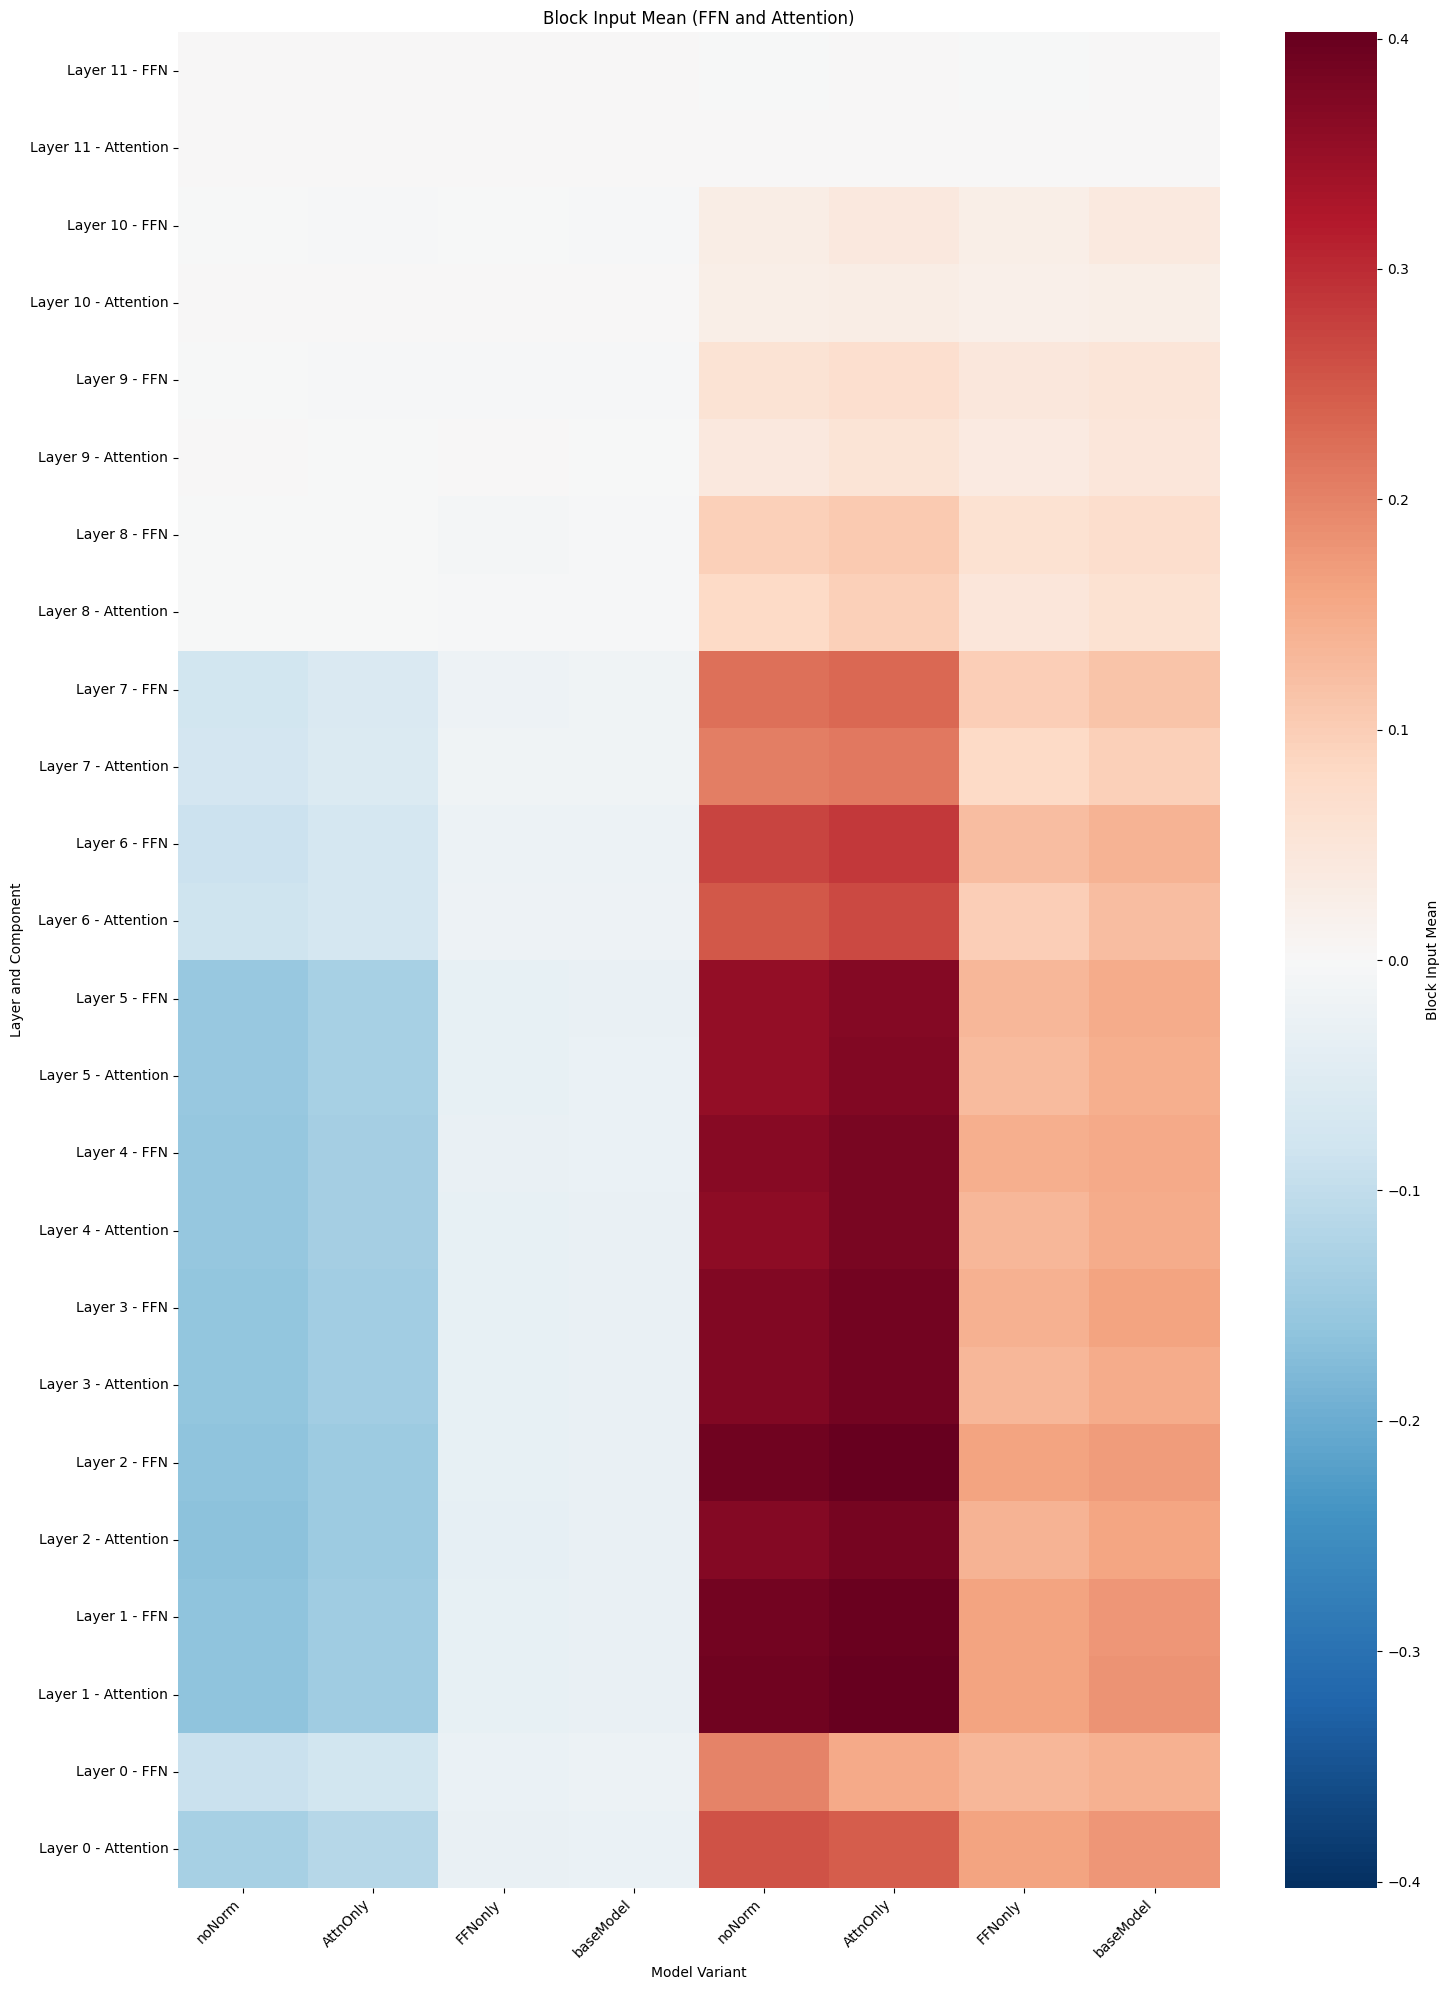

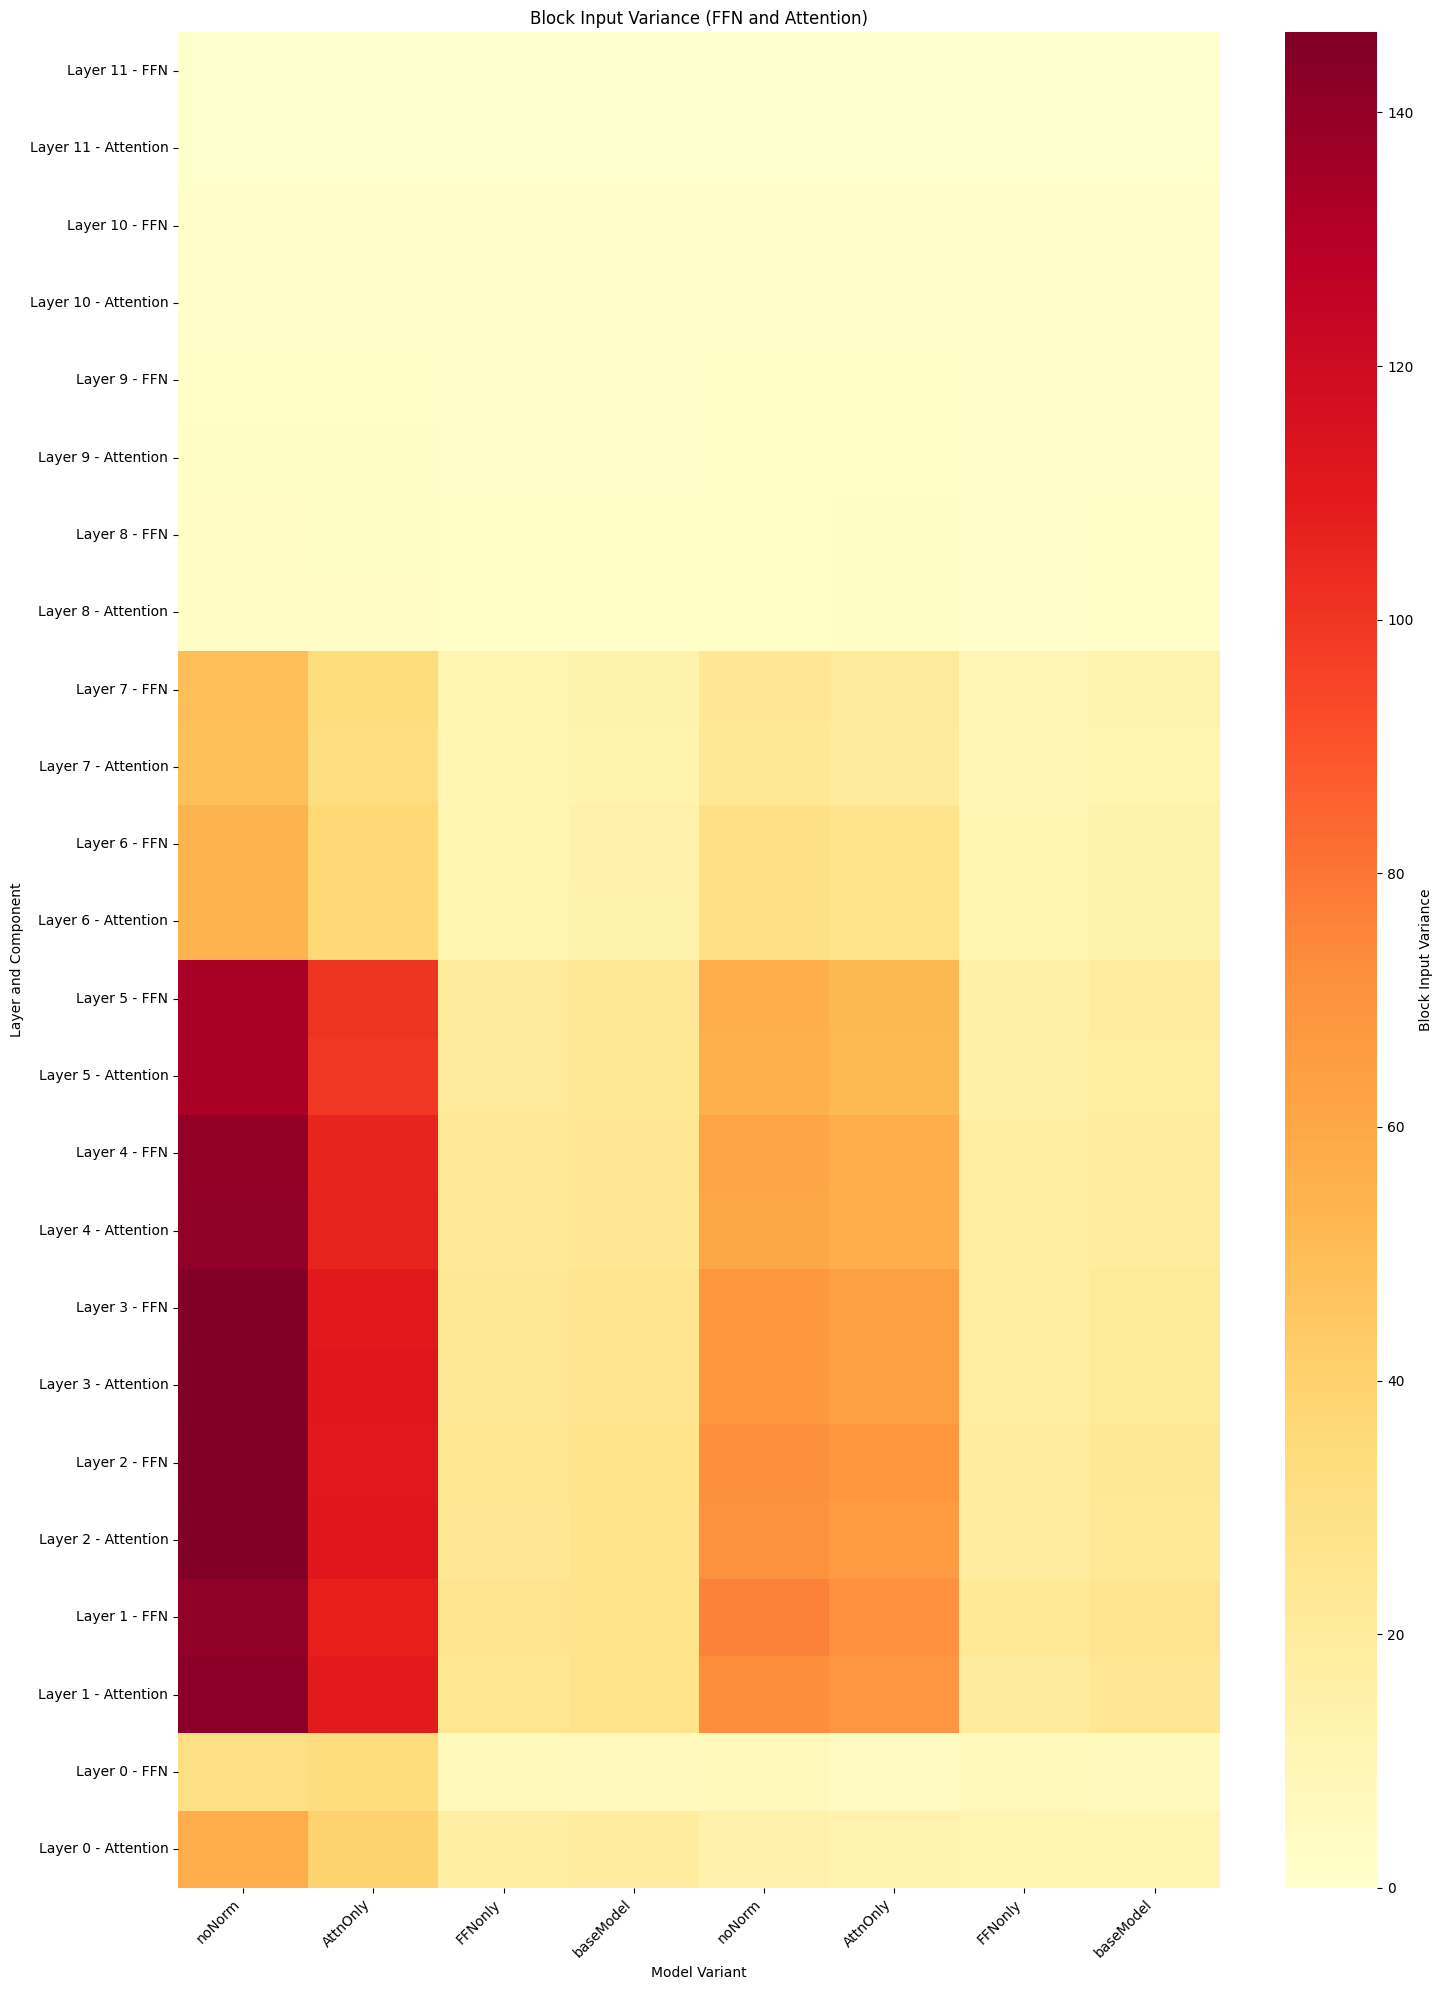

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_block_inputs(model_name, prompt):
    """Extract attention and FFN inputs from each block during forward pass."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    # Store intermediate outputs
    attn_inputs = []
    ffn_inputs = []

    def hook_fn(module, input, output, block_type):
        # Store the input tensor (before normalization)
        if block_type == "attn":
            attn_inputs.append(input[0].detach().float().cpu())  # input[0] is the first input tensor
        else:
            ffn_inputs.append(input[0].detach().float().cpu())

    # Register hooks for each layer
    for block in model.transformer.h:
        # Hook on the ln_1 output for attention (pre-attention norm)
        block.ln_1.register_forward_hook(
            lambda m, i, o, bt="attn": hook_fn(m, i, o, bt)
        )
        # Hook on the ln_2 output for FFN (post-attention norm)
        block.ln_2.register_forward_hook(
            lambda m, i, o, bt="ffn": hook_fn(m, i, o, bt)
        )

    # Forward pass
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Calculate statistics
    attn_stats = []
    ffn_stats = []

    for attn_in, ffn_in in zip(attn_inputs, ffn_inputs):
        attn_stats.append({
            'mean': attn_in.mean().item(),
            'variance': attn_in.var().item()
        })
        ffn_stats.append({
            'mean': ffn_in.mean().item(),
            'variance': ffn_in.var().item()
        })

    del model, outputs
    torch.cuda.empty_cache()

    return attn_stats, ffn_stats

def visualize_block_statistics(all_model_stats, model_variants, stat_type="mean"):
    """Create combined heatmap with alternating FFN and attention rows."""
    # Get number of layers and models
    n_layers = len(all_model_stats[0])
    n_models = len(model_variants)

    # Create arrays for attention and FFN statistics
    attn_stats = np.array([[block['attn'][stat_type] for block in model_stats]
                          for model_stats in all_model_stats])
    ffn_stats = np.array([[block['ffn'][stat_type] for block in model_stats]
                         for model_stats in all_model_stats])

    # Create a combined array where FFN and attention alternate
    combined_stats = np.zeros((n_layers * 2, n_models))
    for i in range(n_layers):
        combined_stats[i*2] = ffn_stats.T[i]      # FFN first
        combined_stats[i*2 + 1] = attn_stats.T[i] # Attention second

    # Create figure
    plt.figure(figsize=(15, 20))

    # Determine scale based on stat type
    if stat_type == "mean":
        abs_max = max(np.abs(attn_stats).max(), np.abs(ffn_stats).max())
        vmin, vmax = -abs_max, abs_max
        cmap = "RdBu_r"
        title_stat = "Mean"
    else:
        vmin = 0
        vmax = max(attn_stats.max(), ffn_stats.max())
        cmap = "YlOrRd"
        title_stat = "Variance"

    # Create y-axis labels
    ylabels = []
    for i in range(n_layers-1, -1, -1):  # Reverse order for top-to-bottom
        ylabels.extend([f'Layer {i} - FFN', f'Layer {i} - Attention'])

    # Create heatmap
    sns.heatmap(combined_stats,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                cbar_kws={'label': f'Block Input {title_stat}'},
                xticklabels=[model.split('__')[1] for model in model_variants],
                yticklabels=ylabels)

    plt.title(f'Block Input {title_stat} (FFN and Attention)')
    plt.xlabel('Model Variant')
    plt.ylabel('Layer and Component')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

def run_text_gen_analysis(prompts):
    """Run analysis for text generation task."""
    model_variants = [
        "shng2025/GPT-Valkyrie_LN-124m__noNorm__",
        "shng2025/GPT-Valkyrie_LN-124m__AttnOnly__",
        "shng2025/GPT-Valkyrie_LN-124m__FFNonly__",
        "shng2025/GPT-Valkyrie_LN-124m__baseModel__",
        "shng2025/GPT-Valkyrie_RMSN-124m__noNorm__",
        "shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__",
        "shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__",
        "shng2025/GPT-Valkyrie_RMSN-124m__baseModel__"
    ]

    all_model_stats = []

    for model_name in model_variants:
        print(f"Processing {model_name}")
        model_stats = []

        for prompt in prompts:
            attn_stats, ffn_stats = get_block_inputs(model_name, prompt)
            model_stats.append({
                'attn': attn_stats,
                'ffn': ffn_stats
            })

        # Average across prompts
        avg_stats = []
        num_layers = len(model_stats[0]['attn'])

        for layer in range(num_layers):
            avg_stats.append({
                'attn': {
                    'mean': np.mean([stats['attn'][layer]['mean'] for stats in model_stats]),
                    'variance': np.mean([stats['attn'][layer]['variance'] for stats in model_stats])
                },
                'ffn': {
                    'mean': np.mean([stats['ffn'][layer]['mean'] for stats in model_stats]),
                    'variance': np.mean([stats['ffn'][layer]['variance'] for stats in model_stats])
                }
            })

        all_model_stats.append(avg_stats)

    # Create visualizations for both mean and variance
    visualize_block_statistics(all_model_stats, model_variants, "mean")
    visualize_block_statistics(all_model_stats, model_variants, "variance")

# Example usage
if __name__ == "__main__":
    prompts = [
        "The spaceship landed softly on the alien planet, and the hatch began to open.",
        "In the depths of the ancient forest, a mysterious light flickered between the trees."
    ]
    run_text_gen_analysis(prompts)

Processing shng2025/GPT-Valkyrie_LN-124m__noNorm__
Processing shng2025/GPT-Valkyrie_LN-124m__AttnOnly__


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Processing shng2025/GPT-Valkyrie_LN-124m__FFNonly__


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Processing shng2025/GPT-Valkyrie_LN-124m__baseModel__


config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Processing shng2025/GPT-Valkyrie_RMSN-124m__noNorm__


config.json:   0%|          | 0.00/842 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Processing shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Processing shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__


config.json:   0%|          | 0.00/845 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Processing shng2025/GPT-Valkyrie_RMSN-124m__baseModel__


config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

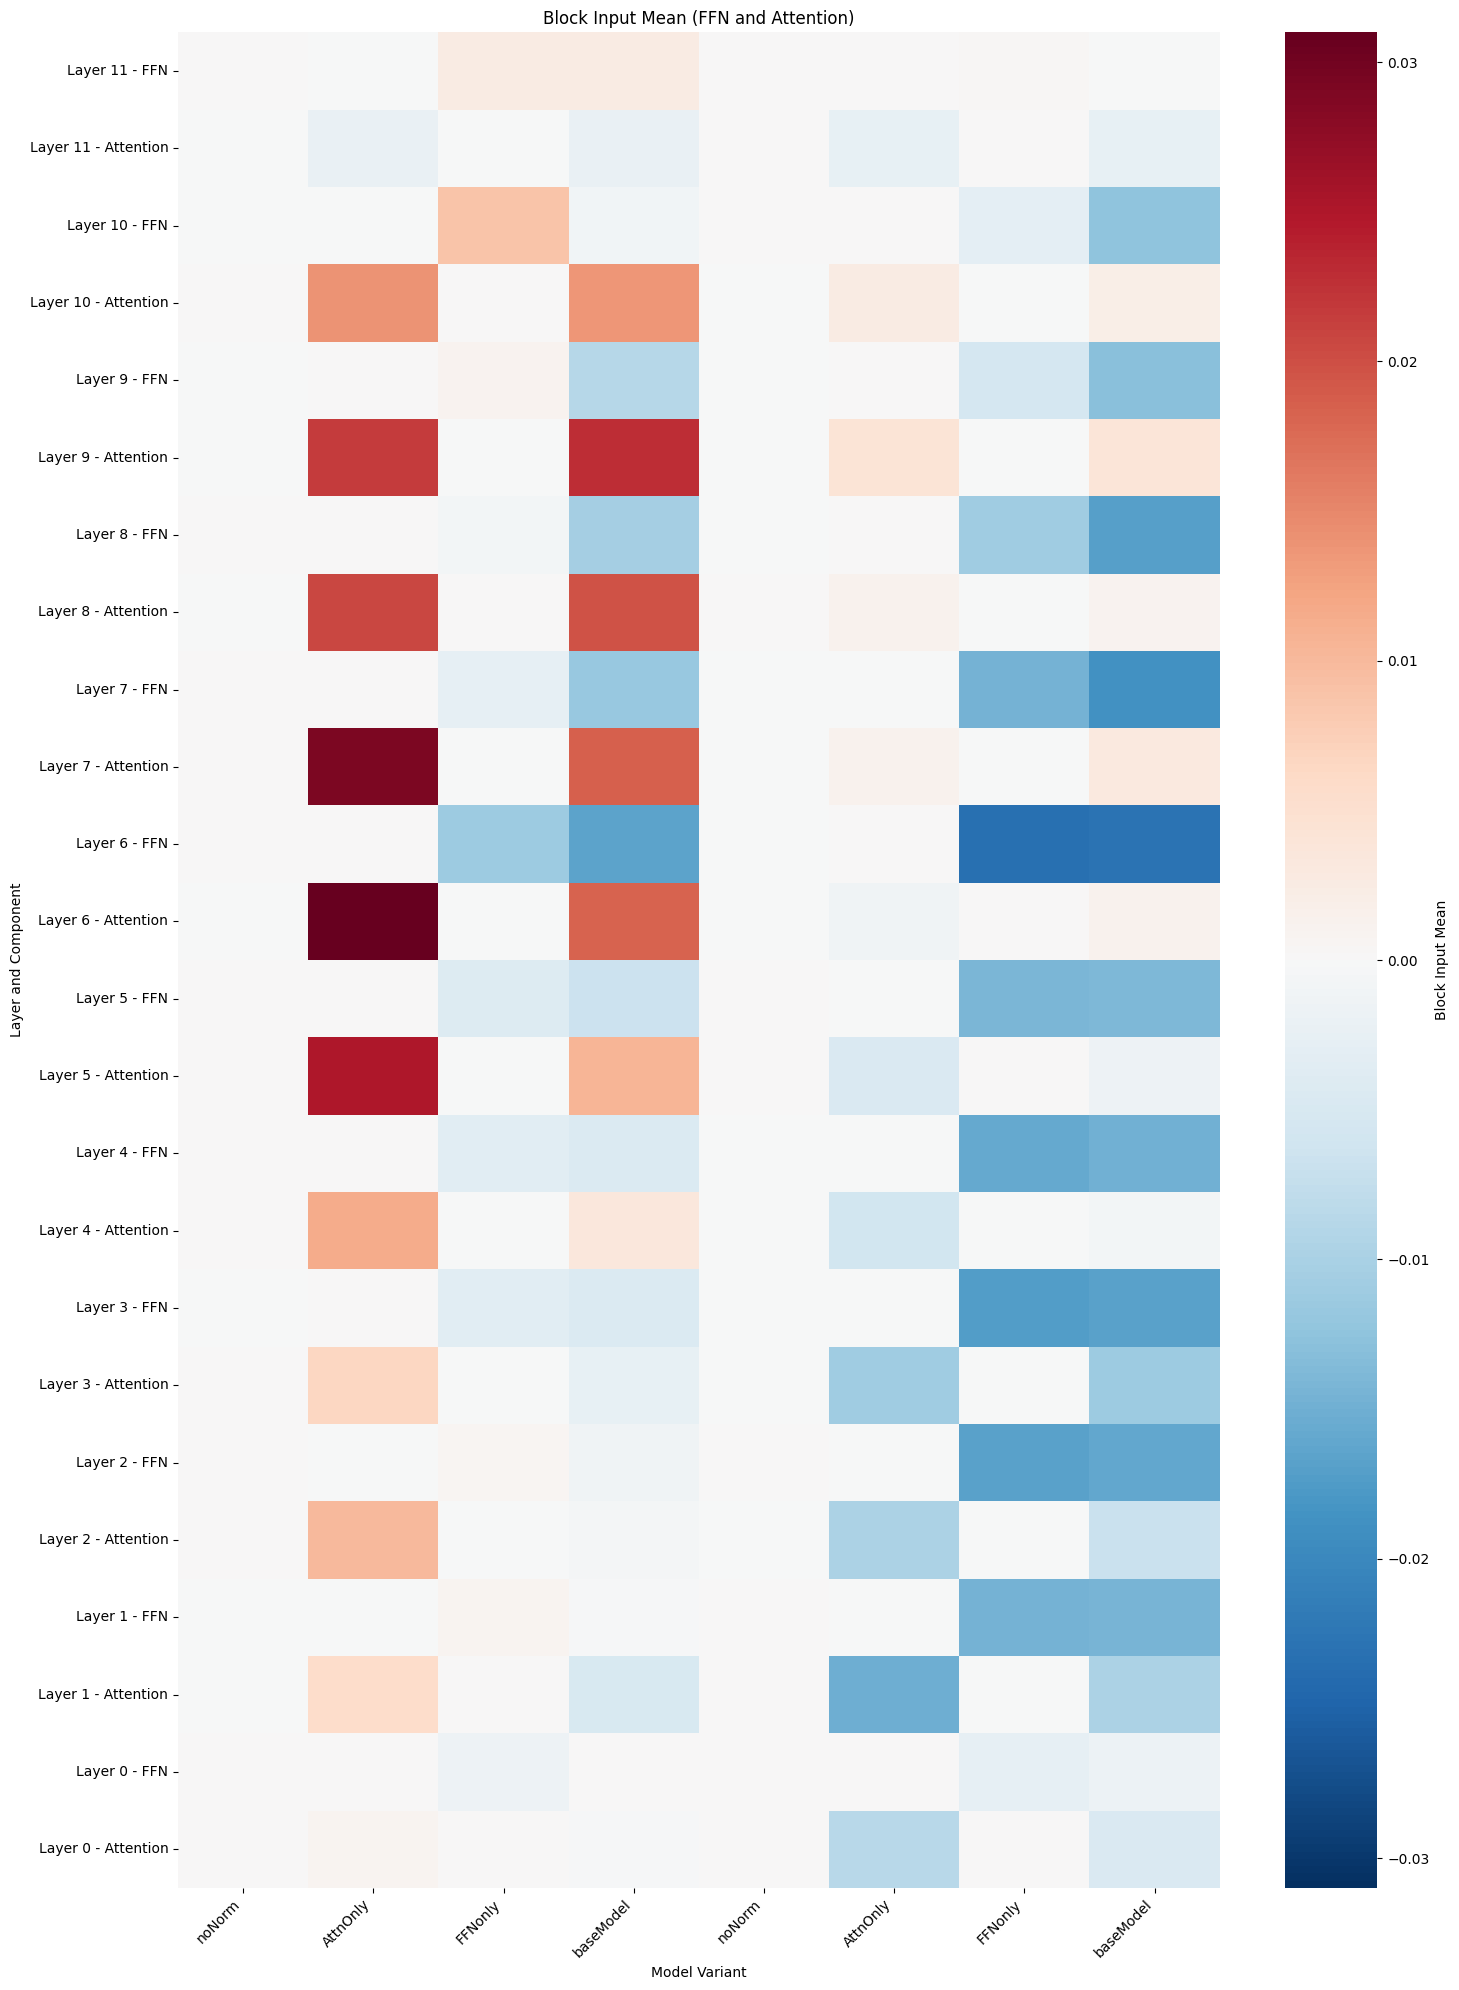

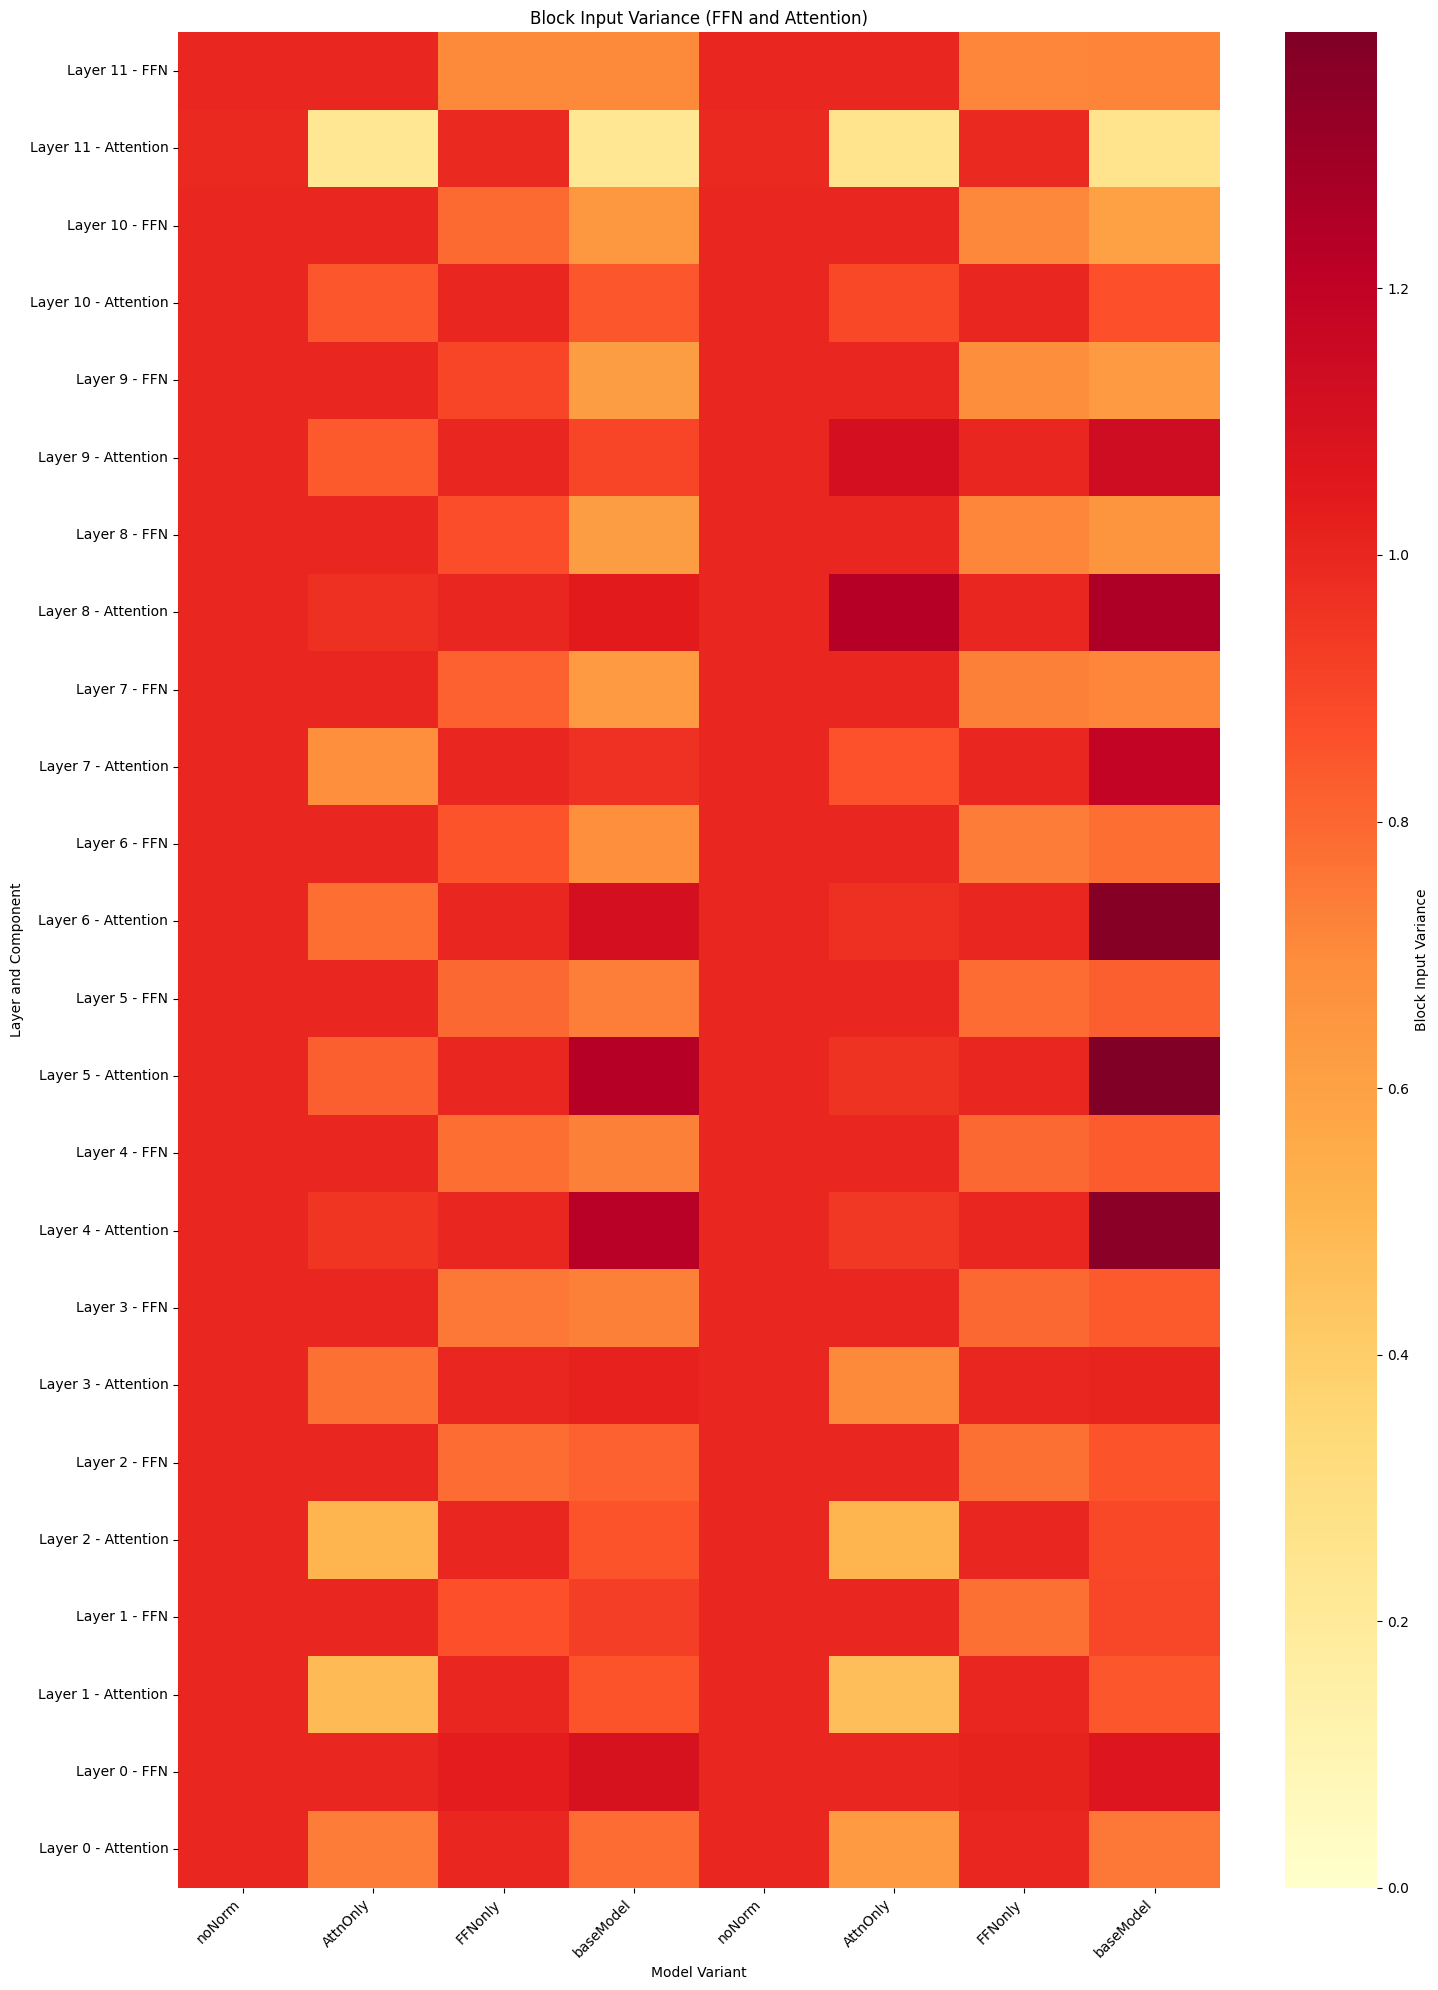

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_block_inputs(model_name, prompt):
    """Extract attention and FFN inputs from each block during forward pass."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    # Store intermediate outputs
    attn_inputs = []
    ffn_inputs = []

    def ln_hook_fn(module, input, output, block_type, layer_idx):
        if block_type == "attn":
            attn_inputs.append(output.detach().float().cpu())
        else:
            ffn_inputs.append(output.detach().float().cpu())

    # Register hooks for each layer
    for idx, block in enumerate(model.transformer.h):
        # Hook on the layer norms' outputs
        block.ln_1.register_forward_hook(
            lambda m, i, o, idx=idx: ln_hook_fn(m, i, o, "attn", idx)
        )
        block.ln_2.register_forward_hook(
            lambda m, i, o, idx=idx: ln_hook_fn(m, i, o, "ffn", idx)
        )

    # Forward pass
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Calculate statistics
    attn_stats = []
    ffn_stats = []

    for attn_in, ffn_in in zip(attn_inputs, ffn_inputs):
        attn_stats.append({
            'mean': attn_in.mean().item(),
            'variance': attn_in.var().item()
        })
        ffn_stats.append({
            'mean': ffn_in.mean().item(),
            'variance': ffn_in.var().item()
        })

        # Debug: Print running stats
        # print(f"\nLayer {len(attn_stats)-1} final stats:")
        # print(f"Attention input - Mean: {attn_stats[-1]['mean']:.4f}, Var: {attn_stats[-1]['variance']:.4f}")
        # print(f"FFN input - Mean: {ffn_stats[-1]['mean']:.4f}, Var: {ffn_stats[-1]['variance']:.4f}")

    del model, outputs
    torch.cuda.empty_cache()

    return attn_stats, ffn_stats

# Rest of visualization code remains the same...

def visualize_block_statistics(all_model_stats, model_variants, stat_type="mean"):
    """Create combined heatmap with alternating FFN and attention rows."""
    # Get number of layers and models
    n_layers = len(all_model_stats[0])
    n_models = len(model_variants)

    # Create arrays for attention and FFN statistics
    attn_stats = np.array([[block['attn'][stat_type] for block in model_stats]
                          for model_stats in all_model_stats])
    ffn_stats = np.array([[block['ffn'][stat_type] for block in model_stats]
                         for model_stats in all_model_stats])

    # Create a combined array where FFN and attention alternate
    combined_stats = np.zeros((n_layers * 2, n_models))
    for i in range(n_layers):
        combined_stats[i*2] = ffn_stats.T[i]      # FFN first
        combined_stats[i*2 + 1] = attn_stats.T[i] # Attention second

    # Create figure
    plt.figure(figsize=(15, 20))

    # Determine scale based on stat type
    if stat_type == "mean":
        abs_max = max(np.abs(attn_stats).max(), np.abs(ffn_stats).max())
        vmin, vmax = -abs_max, abs_max
        cmap = "RdBu_r"
        title_stat = "Mean"
    else:
        vmin = 0
        vmax = max(attn_stats.max(), ffn_stats.max())
        cmap = "YlOrRd"
        title_stat = "Variance"

    # Create y-axis labels
    ylabels = []
    for i in range(n_layers-1, -1, -1):  # Reverse order for top-to-bottom
        ylabels.extend([f'Layer {i} - FFN', f'Layer {i} - Attention'])

    # Create heatmap
    sns.heatmap(combined_stats,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                cbar_kws={'label': f'Block Input {title_stat}'},
                xticklabels=[model.split('__')[1] for model in model_variants],
                yticklabels=ylabels)

    plt.title(f'Block Input {title_stat} (FFN and Attention)')
    plt.xlabel('Model Variant')
    plt.ylabel('Layer and Component')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

def run_text_gen_analysis(prompts):
    """Run analysis for text generation task."""
    model_variants = [
        "shng2025/GPT-Valkyrie_LN-124m__noNorm__",
        "shng2025/GPT-Valkyrie_LN-124m__AttnOnly__",
        "shng2025/GPT-Valkyrie_LN-124m__FFNonly__",
        "shng2025/GPT-Valkyrie_LN-124m__baseModel__",
        "shng2025/GPT-Valkyrie_RMSN-124m__noNorm__",
        "shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__",
        "shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__",
        "shng2025/GPT-Valkyrie_RMSN-124m__baseModel__"
    ]

    all_model_stats = []

    for model_name in model_variants:
        print(f"Processing {model_name}")
        model_stats = []

        for prompt in prompts:
            attn_stats, ffn_stats = get_block_inputs(model_name, prompt)
            model_stats.append({
                'attn': attn_stats,
                'ffn': ffn_stats
            })

        # Average across prompts
        avg_stats = []
        num_layers = len(model_stats[0]['attn'])

        for layer in range(num_layers):
            avg_stats.append({
                'attn': {
                    'mean': np.mean([stats['attn'][layer]['mean'] for stats in model_stats]),
                    'variance': np.mean([stats['attn'][layer]['variance'] for stats in model_stats])
                },
                'ffn': {
                    'mean': np.mean([stats['ffn'][layer]['mean'] for stats in model_stats]),
                    'variance': np.mean([stats['ffn'][layer]['variance'] for stats in model_stats])
                }
            })

        all_model_stats.append(avg_stats)

    # Create visualizations for both mean and variance
    visualize_block_statistics(all_model_stats, model_variants, "mean")
    visualize_block_statistics(all_model_stats, model_variants, "variance")

# Example usage
if __name__ == "__main__":
    prompts = [
        "The spaceship landed softly on the alien planet, and the hatch began to open.",
        "In a quiet village, a cat with mysterious powers arrived one rainy evening.",
        "The treasure map led them to a cave that had never been discovered before.",
        "As the clock struck midnight, the mirror began to shimmer.",
        "The forest was said to be cursed, but she ventured inside anyway.",
        "A mysterious letter arrived in the mail, addressed to someone who no longer lived here.",
        "At the bottom of the ocean, they found a door that led to another world.",
        "The robot slowly gained emotions, surprising its creators.",
        "Every time he fell asleep, he would wake up in a new timeline.",
        "They say that whoever solves the riddle of the ancient book gains unlimited knowledge.",
        "The day the stars disappeared, humanity knew something was coming.",
        "A portal opened in the backyard, leading to a dimension of pure imagination.",
        "The detective knew this was no ordinary case when the painting began to move.",
        "On her 18th birthday, she discovered she could control the wind.",
        "The world froze in time, except for one boy.",
        "The enchanted necklace began to glow whenever danger was near.",
        "He had only one chance to change the past, and the clock was ticking.",
        "The library was full of books no one had ever read before, and each held a hidden secret.",
        "A voice from the radio gave her instructions for an impossible mission.",
        "The moment she touched the ancient artifact, visions flooded her mind.",
        "In the attic, they found a diary that told of future events.",
        "A dragon had been asleep under the city for centuries, and now it was waking up.",
        "Each time he looked in the mirror, a different person stared back.",
        "A storm brought something unexpected to the small town.",
        "Her drawings started coming to life one by one.",
        "The message in the bottle warned of a great danger.",
        "The town vanished overnight, leaving only one survivor.",
        "He discovered that every wish he made came with a price.",
        "A snowstorm trapped them in the cabin, but they weren't alone.",
        "The clock in the town square began running backward.",
        "As the comet passed, everyone suddenly gained strange abilities.",
        "The bridge appeared only under a full moon.",
        "A stray cat followed him everywhere, but it wasn't an ordinary cat.",
        "The carnival arrived without warning, and so did the strange occurrences.",
        "In his dreams, a mysterious figure kept warning him about the future.",
        "Every door in the house led to a different world.",
        "The garden bloomed with flowers no one had ever seen before.",
        "A mysterious shadow followed her everywhere she went.",
        "The phone rang, and the voice on the other end knew too much.",
        "The clockmaker's new invention could turn back time.",
        "The lighthouse was abandoned, but its light still shone every night.",
        "Every star in the night sky represented a different soul.",
        "The forest whispered secrets to those who listened closely.",
        "The old camera developed pictures from events that hadn’t happened yet.",
        "A message appeared on her phone, and it was from the future.",
        "The ghost offered a deal too good to be true.",
        "A library card granted access to books that didn’t exist in the real world.",
        "As soon as they touched the stone, they were transported to another realm.",
        "Each song on the old record player told a different person’s life story.",
        "They found a map that changed every time they looked at it."
    ]
    run_text_gen_analysis(prompts)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def verify_layer_behavior(model_name):
    """Verify if layer norms are actually performing normalization or identity function."""
    print(f"\nVerifying model: {model_name}")

    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained("gpt2")

    # Use appropriate prompt based on model type
    if "SQuAD" in model_name:
        text = "Context: The quick brown fox jumps over the lazy dog.\nQuestion: What did the fox do?\nAnswer:"
    else:  # Billsum
        text = "Bill Text: This act shall be known as the Quick Brown Fox Act.\nSummary:"

    inputs = tokenizer(text, return_tensors="pt")

    # Store layer statistics
    layer_stats = []

    def hook_fn(module, input, output, block_idx, ln_type):
        # Get input and output statistics
        in_tensor = input[0].detach().float()
        out_tensor = output.detach().float()

        # Calculate stats across all dimensions except batch
        in_stats = {
            'mean': in_tensor.mean().item(),
            'var': in_tensor.var().item(),
            'std': in_tensor.std().item(),
        }

        out_stats = {
            'mean': out_tensor.mean().item(),
            'var': out_tensor.var().item(),
            'std': out_tensor.std().item(),
        }

        # Check if this is effectively an identity function
        is_identity = torch.allclose(in_tensor, out_tensor, rtol=1e-3, atol=1e-3)

        # Check if output is normalized (mean ≈ 0, var ≈ 1)
        is_normalized = (abs(out_stats['mean']) < 0.1 and
                        abs(out_stats['var'] - 1.0) < 0.1)

        layer_stats.append({
            'block': block_idx,
            'type': ln_type,
            'input': in_stats,
            'output': out_stats,
            'is_identity': is_identity,
            'is_normalized': is_normalized,
            'weight_mean': module.weight.mean().item() if hasattr(module, 'weight') else None,
            'weight_std': module.weight.std().item() if hasattr(module, 'weight') else None,
            'bias_mean': module.bias.mean().item() if hasattr(module, 'bias') else None,
            'bias_std': module.bias.std().item() if hasattr(module, 'bias') else None
        })

    # Register hooks for each layer
    for idx, block in enumerate(model.transformer.h):
        block.ln_1.register_forward_hook(
            lambda m, i, o, idx=idx: hook_fn(m, i, o, idx, 'ln_1')
        )
        block.ln_2.register_forward_hook(
            lambda m, i, o, idx=idx: hook_fn(m, i, o, idx, 'ln_2')
        )

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Analyze results
    ablation_type = model_name.split('__')[1]
    print(f"\nAblation type: {ablation_type}")

    def print_layer_summary(stats):
        is_identity_count = sum(1 for s in stats if s['is_identity'])
        is_normalized_count = sum(1 for s in stats if s['is_normalized'])
        print(f"Total layers behaving as identity: {is_identity_count}/{len(stats)}")
        print(f"Total layers performing normalization: {is_normalized_count}/{len(stats)}")

        # Print detailed stats for first few layers
        for s in stats[:3]:  # First 3 layers as example
            print(f"\nBlock {s['block']} - {s['type']}:")
            print(f"Input  - Mean: {s['input']['mean']:.4f}, Var: {s['input']['var']:.4f}")
            print(f"Output - Mean: {s['output']['mean']:.4f}, Var: {s['output']['var']:.4f}")
            if s['weight_mean'] is not None:
                print(f"Weight - Mean: {s['weight_mean']:.4f}, Std: {s['weight_std']:.4f}")
                print(f"Bias   - Mean: {s['bias_mean']:.4f}, Std: {s['bias_std']:.4f}")
            print(f"Is Identity: {s['is_identity']}, Is Normalized: {s['is_normalized']}")

    # Split stats by layer type
    ln1_stats = [s for s in layer_stats if s['type'] == 'ln_1']
    ln2_stats = [s for s in layer_stats if s['type'] == 'ln_2']

    print("\nLN1 (Pre-Attention) Summary:")
    print_layer_summary(ln1_stats)
    print("\nLN2 (Pre-FFN) Summary:")
    print_layer_summary(ln2_stats)

    return layer_stats

# First verify SQuAD models
squad_variants = [
    "shng2025/GPT-Valkyrie_LN-124m__noNorm__SQuAD",
    "shng2025/GPT-Valkyrie_LN-124m__AttnOnly__SQuAD",
    "shng2025/GPT-Valkyrie_LN-124m__FFNonly__SQuAD",
    "shng2025/GPT-Valkyrie_LN-124m__baseModel__SQuAD",
    "shng2025/GPT-Valkyrie_RMSN-124m__noNorm__SQuAD",
    "shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__SQuAD",
    "shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__SQuAD",
    "shng2025/GPT-Valkyrie_RMSN-124m__baseModel__SQuAD"
]

print("\nVerifying SQuAD Models")
print("="*50)
for model_name in squad_variants:
    stats = verify_layer_behavior(model_name)
    plt.figure(figsize=(15, 10))
    plt.title(f"Layer Statistics for {model_name}")
    # Add visualization code here if needed
    plt.close()

# Then verify Billsum models
billsum_variants = [
    "shng2025/GPT-Valkyrie_LN-124m__noNorm__Billsum",
    "shng2025/GPT-Valkyrie_LN-124m__AttnOnly__Billsum",
    "shng2025/GPT-Valkyrie_LN-124m__FFNonly__Billsum",
    "shng2025/GPT-Valkyrie_LN-124m__baseModel__Billsum",
    "shng2025/GPT-Valkyrie_RMSN-124m__noNorm__Billsum",
    "shng2025/GPT-Valkyrie_RMSN-124m__AttnOnly__Billsum",
    "shng2025/GPT-Valkyrie_RMSN-124m__FFNonly__Billsum",
    "shng2025/GPT-Valkyrie_RMSN-124m__baseModel__Billsum"
]

print("\nVerifying Billsum Models")
print("="*50)
for model_name in billsum_variants:
    stats = verify_layer_behavior(model_name)
    plt.figure(figsize=(15, 10))
    plt.title(f"Layer Statistics for {model_name}")
    # Add visualization code here if needed
    plt.close()


Verifying SQuAD Models

Verifying model: shng2025/GPT-Valkyrie_LN-124m__noNorm__SQuAD


config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Ablation type: noNorm

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_1:
Input  - Mean: 0.0005, Var: 0.0019
Output - Mean: -0.0000, Var: 0.9937
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 1 - ln_1:
Input  - Mean: -0.0000, Var: 1.3602
Output - Mean: -0.0000, Var: 1.0000
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 2 - ln_1:
Input  - Mean: -0.0017, Var: 2.1679
Output - Mean: 0.0000, Var: 1.0000
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_2:
Input  - Mean: 0.0008, Var: 0.0104
Output - Mean: 0.0000, Var: 0.9988
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
I

config.json:   0%|          | 0.00/854 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Ablation type: AttnOnly

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 4/12

Block 0 - ln_1:
Input  - Mean: 0.0004, Var: 0.0018
Output - Mean: -0.0031, Var: 0.2305
Weight - Mean: 0.4669, Std: 0.0828
Bias   - Mean: -0.0000, Std: 0.0144
Is Identity: False, Is Normalized: False

Block 1 - ln_1:
Input  - Mean: -0.0002, Var: 1.0454
Output - Mean: 0.0099, Var: 0.7074
Weight - Mean: 0.8296, Std: 0.0654
Bias   - Mean: 0.0088, Std: 0.0589
Is Identity: False, Is Normalized: False

Block 2 - ln_1:
Input  - Mean: -0.0044, Var: 1.8215
Output - Mean: 0.0176, Var: 0.6667
Weight - Mean: 0.7851, Std: 0.0588
Bias   - Mean: 0.0138, Std: 0.0457
Is Identity: False, Is Normalized: False

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_2:
Input  - Mean: 0.0003, Var: 0.0031
Output - Mean: -0.0000, Var: 0.9963
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0

config.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Ablation type: FFNonly

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_1:
Input  - Mean: 0.0005, Var: 0.0019
Output - Mean: -0.0002, Var: 0.9770
Weight - Mean: 0.9918, Std: 0.0024
Bias   - Mean: -0.0002, Std: 0.0045
Is Identity: False, Is Normalized: True

Block 1 - ln_1:
Input  - Mean: -0.0009, Var: 0.9618
Output - Mean: -0.0000, Var: 0.9894
Weight - Mean: 0.9960, Std: 0.0016
Bias   - Mean: -0.0000, Std: 0.0017
Is Identity: False, Is Normalized: True

Block 2 - ln_1:
Input  - Mean: -0.0075, Var: 1.6675
Output - Mean: 0.0001, Var: 0.9911
Weight - Mean: 0.9978, Std: 0.0018
Bias   - Mean: -0.0000, Std: 0.0015
Is Identity: False, Is Normalized: True

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 8/12

Block 0 - ln_2:
Input  - Mean: 0.0004, Var: 0.0092
Output - Mean: 0.0025, Var: 0.7005
Weight - Mean: 0.8342, Std: 0.0425
Bias   - Mean: 0.0036, Std: 0.032

config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Ablation type: baseModel

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 3/12

Block 0 - ln_1:
Input  - Mean: 0.0005, Var: 0.0018
Output - Mean: -0.0031, Var: 0.2305
Weight - Mean: 0.4668, Std: 0.0828
Bias   - Mean: 0.0000, Std: 0.0144
Is Identity: False, Is Normalized: False

Block 1 - ln_1:
Input  - Mean: -0.0023, Var: 0.8370
Output - Mean: 0.0102, Var: 0.7108
Weight - Mean: 0.8292, Std: 0.0653
Bias   - Mean: 0.0089, Std: 0.0588
Is Identity: False, Is Normalized: False

Block 2 - ln_1:
Input  - Mean: -0.0105, Var: 1.5607
Output - Mean: 0.0190, Var: 0.6965
Weight - Mean: 0.7842, Std: 0.0587
Bias   - Mean: 0.0138, Std: 0.0460
Is Identity: False, Is Normalized: False

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 11/12

Block 0 - ln_2:
Input  - Mean: 0.0004, Var: 0.0031
Output - Mean: 0.0029, Var: 0.6965
Weight - Mean: 0.8341, Std: 0.0423
Bias   - Mean: 0.0036, Std: 0.03

config.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Ablation type: noNorm

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_1:
Input  - Mean: -0.0000, Var: 0.0019
Output - Mean: -0.0000, Var: 0.9939
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 1 - ln_1:
Input  - Mean: 0.0217, Var: 1.0395
Output - Mean: -0.0000, Var: 1.0000
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 2 - ln_1:
Input  - Mean: 0.0299, Var: 1.7746
Output - Mean: -0.0000, Var: 1.0000
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_2:
Input  - Mean: -0.0010, Var: 0.0087
Output - Mean: -0.0000, Var: 0.9987
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Ablation type: AttnOnly

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 5/12

Block 0 - ln_1:
Input  - Mean: -0.0000, Var: 0.0019
Output - Mean: -0.0025, Var: 0.2515
Weight - Mean: 0.4868, Std: 0.0901
Bias   - Mean: 0.0001, Std: 0.0028
Is Identity: False, Is Normalized: False

Block 1 - ln_1:
Input  - Mean: 0.0182, Var: 0.9834
Output - Mean: -0.0031, Var: 0.6457
Weight - Mean: 0.8264, Std: 0.0711
Bias   - Mean: -0.0001, Std: 0.0017
Is Identity: False, Is Normalized: False

Block 2 - ln_1:
Input  - Mean: 0.0280, Var: 1.6758
Output - Mean: -0.0019, Var: 0.6687
Weight - Mean: 0.8228, Std: 0.0576
Bias   - Mean: 0.0001, Std: 0.0013
Is Identity: False, Is Normalized: False

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_2:
Input  - Mean: 0.0001, Var: 0.0032
Output - Mean: -0.0000, Var: 0.9964
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.

config.json:   0%|          | 0.00/854 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Ablation type: FFNonly

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_1:
Input  - Mean: -0.0000, Var: 0.0019
Output - Mean: 0.0001, Var: 0.9777
Weight - Mean: 0.9919, Std: 0.0023
Bias   - Mean: 0.0001, Std: 0.0039
Is Identity: False, Is Normalized: True

Block 1 - ln_1:
Input  - Mean: 0.0238, Var: 0.8169
Output - Mean: -0.0004, Var: 0.9848
Weight - Mean: 0.9956, Std: 0.0019
Bias   - Mean: -0.0001, Std: 0.0019
Is Identity: False, Is Normalized: True

Block 2 - ln_1:
Input  - Mean: 0.0292, Var: 1.4311
Output - Mean: -0.0004, Var: 0.9843
Weight - Mean: 0.9968, Std: 0.0018
Bias   - Mean: 0.0000, Std: 0.0014
Is Identity: False, Is Normalized: True

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 10/12

Block 0 - ln_2:
Input  - Mean: -0.0017, Var: 0.0081
Output - Mean: 0.0001, Var: 0.7248
Weight - Mean: 0.8572, Std: 0.0428
Bias   - Mean: 0.0001, Std: 0.0020

config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Ablation type: baseModel

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 5/12

Block 0 - ln_1:
Input  - Mean: -0.0000, Var: 0.0019
Output - Mean: -0.0025, Var: 0.2516
Weight - Mean: 0.4866, Std: 0.0900
Bias   - Mean: 0.0001, Std: 0.0027
Is Identity: False, Is Normalized: False

Block 1 - ln_1:
Input  - Mean: 0.0177, Var: 0.7812
Output - Mean: -0.0018, Var: 0.6628
Weight - Mean: 0.8260, Std: 0.0712
Bias   - Mean: -0.0001, Std: 0.0015
Is Identity: False, Is Normalized: False

Block 2 - ln_1:
Input  - Mean: 0.0260, Var: 1.3944
Output - Mean: -0.0016, Var: 0.6917
Weight - Mean: 0.8227, Std: 0.0576
Bias   - Mean: 0.0000, Std: 0.0010
Is Identity: False, Is Normalized: False

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 11/12

Block 0 - ln_2:
Input  - Mean: 0.0001, Var: 0.0033
Output - Mean: -0.0002, Var: 0.7286
Weight - Mean: 0.8571, Std: 0.0426
Bias   - Mean: -0.0000, Std: 

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]


Ablation type: noNorm

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_1:
Input  - Mean: 0.0004, Var: 0.0021
Output - Mean: 0.0000, Var: 0.9942
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 1 - ln_1:
Input  - Mean: 0.0134, Var: 1.0390
Output - Mean: -0.0000, Var: 1.0001
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 2 - ln_1:
Input  - Mean: 0.0132, Var: 2.4657
Output - Mean: -0.0000, Var: 1.0001
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_2:
Input  - Mean: 0.0001, Var: 0.0077
Output - Mean: -0.0000, Var: 0.9984
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is

config.json:   0%|          | 0.00/870 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]


Ablation type: AttnOnly

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 4/12

Block 0 - ln_1:
Input  - Mean: 0.0004, Var: 0.0020
Output - Mean: -0.0023, Var: 0.2281
Weight - Mean: 0.4672, Std: 0.0825
Bias   - Mean: 0.0001, Std: 0.0147
Is Identity: False, Is Normalized: False

Block 1 - ln_1:
Input  - Mean: 0.0135, Var: 0.8356
Output - Mean: 0.0075, Var: 0.6593
Weight - Mean: 0.8224, Std: 0.0644
Bias   - Mean: 0.0087, Std: 0.0592
Is Identity: False, Is Normalized: False

Block 2 - ln_1:
Input  - Mean: 0.0142, Var: 2.1409
Output - Mean: 0.0133, Var: 0.6329
Weight - Mean: 0.7806, Std: 0.0595
Bias   - Mean: 0.0138, Std: 0.0464
Is Identity: False, Is Normalized: False

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_2:
Input  - Mean: 0.0002, Var: 0.0035
Output - Mean: -0.0000, Var: 0.9967
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000

config.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]


Ablation type: FFNonly

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_1:
Input  - Mean: 0.0004, Var: 0.0020
Output - Mean: 0.0000, Var: 0.9942
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 1 - ln_1:
Input  - Mean: 0.0120, Var: 0.9738
Output - Mean: 0.0000, Var: 1.0001
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 2 - ln_1:
Input  - Mean: 0.0145, Var: 2.1921
Output - Mean: 0.0000, Var: 1.0001
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 4/12

Block 0 - ln_2:
Input  - Mean: 0.0001, Var: 0.0073
Output - Mean: 0.0021, Var: 0.6915
Weight - Mean: 0.8318, Std: 0.0414
Bias   - Mean: 0.0036, Std: 0.0315
Is Id

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]


Ablation type: baseModel

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 4/12

Block 0 - ln_1:
Input  - Mean: 0.0004, Var: 0.0020
Output - Mean: -0.0022, Var: 0.2280
Weight - Mean: 0.4672, Std: 0.0824
Bias   - Mean: 0.0001, Std: 0.0147
Is Identity: False, Is Normalized: False

Block 1 - ln_1:
Input  - Mean: 0.0122, Var: 0.7456
Output - Mean: 0.0078, Var: 0.6602
Weight - Mean: 0.8235, Std: 0.0642
Bias   - Mean: 0.0088, Std: 0.0590
Is Identity: False, Is Normalized: False

Block 2 - ln_1:
Input  - Mean: 0.0117, Var: 1.8831
Output - Mean: 0.0135, Var: 0.6378
Weight - Mean: 0.7816, Std: 0.0588
Bias   - Mean: 0.0138, Std: 0.0461
Is Identity: False, Is Normalized: False

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 8/12

Block 0 - ln_2:
Input  - Mean: 0.0003, Var: 0.0034
Output - Mean: 0.0024, Var: 0.6943
Weight - Mean: 0.8316, Std: 0.0408
Bias   - Mean: 0.0036, Std: 0.0316


config.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]


Ablation type: noNorm

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_1:
Input  - Mean: -0.0005, Var: 0.0021
Output - Mean: -0.0000, Var: 0.9944
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 1 - ln_1:
Input  - Mean: 0.0335, Var: 0.9427
Output - Mean: -0.0000, Var: 1.0001
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 2 - ln_1:
Input  - Mean: 0.0601, Var: 2.0069
Output - Mean: 0.0000, Var: 1.0001
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_2:
Input  - Mean: 0.0007, Var: 0.0069
Output - Mean: -0.0000, Var: 0.9983
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
I

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]


Ablation type: AttnOnly

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 4/12

Block 0 - ln_1:
Input  - Mean: -0.0005, Var: 0.0021
Output - Mean: -0.0020, Var: 0.2480
Weight - Mean: 0.4867, Std: 0.0895
Bias   - Mean: 0.0000, Std: 0.0022
Is Identity: False, Is Normalized: False

Block 1 - ln_1:
Input  - Mean: 0.0382, Var: 0.7353
Output - Mean: -0.0024, Var: 0.6378
Weight - Mean: 0.8195, Std: 0.0701
Bias   - Mean: -0.0002, Std: 0.0036
Is Identity: False, Is Normalized: False

Block 2 - ln_1:
Input  - Mean: 0.0602, Var: 1.6857
Output - Mean: -0.0031, Var: 0.6567
Weight - Mean: 0.8193, Std: 0.0581
Bias   - Mean: 0.0000, Std: 0.0020
Is Identity: False, Is Normalized: False

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_2:
Input  - Mean: 0.0001, Var: 0.0037
Output - Mean: -0.0000, Var: 0.9968
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.

config.json:   0%|          | 0.00/870 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]


Ablation type: FFNonly

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 12/12

Block 0 - ln_1:
Input  - Mean: -0.0005, Var: 0.0021
Output - Mean: -0.0000, Var: 0.9944
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 1 - ln_1:
Input  - Mean: 0.0340, Var: 0.8344
Output - Mean: -0.0000, Var: 1.0001
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

Block 2 - ln_1:
Input  - Mean: 0.0570, Var: 1.8003
Output - Mean: -0.0000, Var: 1.0001
Weight - Mean: 1.0000, Std: 0.0000
Bias   - Mean: 0.0000, Std: 0.0000
Is Identity: False, Is Normalized: True

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 6/12

Block 0 - ln_2:
Input  - Mean: 0.0007, Var: 0.0068
Output - Mean: -0.0001, Var: 0.7169
Weight - Mean: 0.8540, Std: 0.0420
Bias   - Mean: 0.0003, Std: 0.0036


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]


Ablation type: baseModel

LN1 (Pre-Attention) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 4/12

Block 0 - ln_1:
Input  - Mean: -0.0005, Var: 0.0021
Output - Mean: -0.0020, Var: 0.2479
Weight - Mean: 0.4867, Std: 0.0895
Bias   - Mean: 0.0000, Std: 0.0023
Is Identity: False, Is Normalized: False

Block 1 - ln_1:
Input  - Mean: 0.0360, Var: 0.6625
Output - Mean: -0.0024, Var: 0.6281
Weight - Mean: 0.8204, Std: 0.0701
Bias   - Mean: -0.0002, Std: 0.0036
Is Identity: False, Is Normalized: False

Block 2 - ln_1:
Input  - Mean: 0.0556, Var: 1.5358
Output - Mean: -0.0031, Var: 0.6414
Weight - Mean: 0.8200, Std: 0.0578
Bias   - Mean: -0.0000, Std: 0.0020
Is Identity: False, Is Normalized: False

LN2 (Pre-FFN) Summary:
Total layers behaving as identity: 0/12
Total layers performing normalization: 9/12

Block 0 - ln_2:
Input  - Mean: 0.0003, Var: 0.0036
Output - Mean: -0.0006, Var: 0.7292
Weight - Mean: 0.8538, Std: 0.0414
Bias   - Mean: 0.0002, Std: 0